In [7]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
import pandas as pd
import re
import warnings
import random
import matplotlib
from tqdm.notebook import tqdm
from matplotlib.patches import Patch
from scipy.stats import linregress, spearmanr
import analysis_utils 
from copy import deepcopy
import importlib

# path to repository folder (data is stored here as well)
path = '..'
preds_loc = os.path.join(path, 'data', 'analysis', 'ssym_flat_analysis.csv')

# default plotting settings
font = {'size'   : 18}
matplotlib.rc('font', **font)

# notebook display options
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 300

remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

db = pd.read_csv(preds_loc).set_index(['uid', 'uid2'])

db_stacked = analysis_utils.stack_frames(db)
db_stacked_preds = db_stacked[[c for c in db_stacked.columns if not 'runtime' in c]]
db_stacked_runtimes = db_stacked[[c for c in db_stacked.columns if 'runtime' in c]]
db_stacked_runtimes

pred_col             runtime_ankh  runtime_esm1v_1  runtime_esm1v_2  \
direction uid                                                         
dir       1AMQ_191F      0.182606         0.067344         0.066230   
          1AMQ_191S      0.181212         0.066351         0.066204   
          1AMQ_191W      0.180855         0.066890         0.066931   
          1AMQ_191Y      0.180631         0.067232         0.066729   
          1BNI_14A       0.107334         0.034200         0.031118   
...                           ...              ...              ...   
inv       5PTI_22A       0.112357         0.030202         0.028447   
          5PTI_23A       0.106133         0.030067         0.028884   
          5PTI_35G       0.105802         0.030636         0.031073   
          5PTI_43G       0.105657         0.030900         0.028669   
          5PTI_45A       0.095485         0.032464         0.027214   

pred_col             runtime_esm1v_3  runtime_esm1v_4  runtime_esm1v_5  \
direction uid                                                            
dir       1AMQ_191F         0.066228         0.066444         0.065980   
          1AMQ_191S         0.066053         0.066372         0.066340   
          1AMQ_191W         0.066286         0.071942         0.066381   
          1AMQ_191Y         0.066720         0.066427         0.066803   
          1BNI_14A          0.030738         0.030340         0.031391   
...                              ...              ...              ...   
inv       5PTI_22A          0.029896         0.029325         0.031306   
          5PTI_23A          0.030771         0.032039         0.030846   
          5PTI_35G          0.030899         0.031054         0.029357   
          5PTI_43G          0.031164         0.030806         0.030116   
          5PTI_45A          0.030750         0.029823         0.026830   

pred_col             runtime_esm1v_mean  runtime_esm1v_median  \
direction uid                                                   
dir       1AMQ_191F            0.332226              0.332226   
          1AMQ_191S            0.331320              0.331320   
          1AMQ_191W            0.338431              0.338431   
          1AMQ_191Y            0.333911              0.333911   
          1BNI_14A             0.157787              0.157787   
...                                 ...                   ...   
inv       5PTI_22A             0.149177              0.149177   
          5PTI_23A             0.152607              0.152607   
          5PTI_35G             0.153019              0.153019   
          5PTI_43G             0.151654              0.151654   
          5PTI_45A             0.147081              0.147081   

pred_col             runtime_esm2_150M  runtime_esm2_15B_half  ...  \
direction uid                                                  ...   
dir       1AMQ_191F           0.043972               0.096341  ...   
          1AMQ_191S           0.037393               0.096246  ...   
          1AMQ_191W           0.035516               0.095777  ...   
          1AMQ_191Y           0.035152               0.096348  ...   
          1BNI_14A            0.036107               0.053321  ...   
...                                ...                    ...  ...   
inv       5PTI_22A            0.042100               0.043578  ...   
          5PTI_23A            0.042042               0.046525  ...   
          5PTI_35G            0.032007               0.042571  ...   
          5PTI_43G            0.042175               0.043649  ...   
          5PTI_45A            0.040100               0.044160  ...   

pred_col             runtime_mpnn_20_00  runtime_mpnn_30_00  runtime_msa_1  \
direction uid                                                                
dir       1AMQ_191F            0.016232            0.016989       3.390493   
          1AMQ_191S            0.014761            0.016065       3.393482   
          1AMQ_191W            0.014751     

Original unique mutations: 684
['direction', 'uid', 'ACDC-NN', 'ACDC-NN-Seq', 'Cartddg', 'DDG', 'DDGun', 'DDGun3D', 'DUET', 'Dynamut', 'Dynamut2', 'Evo', 'FoldX', 'I-Mutant3.0', 'I-Mutant3.0-Seq', 'INPS-Seq', 'INPS3D', 'KORPM', 'MAESTRO', 'MUpro', 'PoPMuSiC', 'PremPS', 'SAAFEC-SEQ', 'SDM', 'ThermoNet', 'ankh', 'cartesian_ddg', 'esm1v_mean', 'esm1v_median', 'esm2_150M', 'esm2_15B_half', 'esm2_3B', 'esm2_650M', 'esmif_monomer', 'esmif_multimer', 'korpm', 'mCSM', 'mif', 'mifst', 'mpnn_10_00', 'mpnn_20_00', 'mpnn_30_00', 'msa_transformer_mean', 'msa_transformer_median', 'mutcomputex', 'stability-oracle', 'tranception']
cluster
1      28
2     368
3      10
4       2
5       6
6      36
7       6
8     150
9      56
10      8
11     10
12      4
Name: direction, dtype: int64
Unique mutations in chosen set: 684
Unique clusters (protein families with significant structural homology): 12


pred_col,direction,uid,ACDC-NN,ACDC-NN-Seq,Cartddg,DDG,DDGun,DDGun3D,DUET,Dynamut,...,mpnn_30_00,msa_transformer_mean,msa_transformer_median,mutcomputex,stability-oracle,tranception,ddG,cluster,mpnn_rosetta,random
0,dir,1AMQ_191F,0.155387,0.000000,-8.00,-1.6,0.9,0.9,-0.992,0.800,...,-4.185785,-11.279768,-11.458145,-0.072907,-1.094,-0.030816,-1.6,10,-9.940203,-0.212999
1,dir,1AMQ_191S,-0.310174,0.000000,-4.22,-1.9,0.2,-0.5,-1.717,-0.149,...,-0.763924,-5.687223,-5.619745,0.152491,-1.204,-0.015824,-1.9,10,-5.129149,-0.882922
2,dir,1AMQ_191W,0.175478,0.000235,-8.00,-3.9,1.1,1.0,-1.495,1.222,...,-4.321257,-13.326253,-13.317976,-0.072507,-1.124,-0.039274,-3.9,10,-21.056967,-0.144470
3,dir,1AMQ_191Y,0.255306,0.007419,-7.80,-2.3,1.3,1.3,-1.307,1.210,...,-4.159512,-11.288756,-11.298208,-0.072155,-1.136,-0.029105,-2.3,10,-11.157171,1.685126
4,dir,1BNI_14A,-1.032232,-1.280774,-8.00,-4.5,-3.1,-3.1,-3.172,-2.526,...,-4.914061,-12.701860,-13.243906,-0.994928,-3.670,-0.079214,-4.5,1,-14.114356,-0.760150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,inv,5PTI_22A,1.446976,1.744492,1.97,1.2,2.7,2.8,-0.819,0.996,...,-3.072806,8.379252,8.087660,-0.907782,-0.770,0.047729,1.2,11,2.231657,-0.523183
680,inv,5PTI_23A,2.190413,3.002760,4.56,5.9,4.2,3.8,-0.888,1.028,...,5.011670,12.005811,11.668735,-0.084975,2.360,0.104299,5.9,11,11.405331,1.636057
681,inv,5PTI_35G,2.394038,3.046156,-0.56,5.0,4.5,3.6,-1.774,1.082,...,-5.357002,10.283704,10.450047,-0.999981,-1.340,0.091949,5.0,11,-4.590325,-0.441652
682,inv,5PTI_43G,1.418397,1.558716,3.24,5.7,2.1,1.5,-0.450,1.228,...,4.293312,9.196254,9.729218,-0.999996,-0.437,0.055134,5.7,11,15.060090,-0.276564


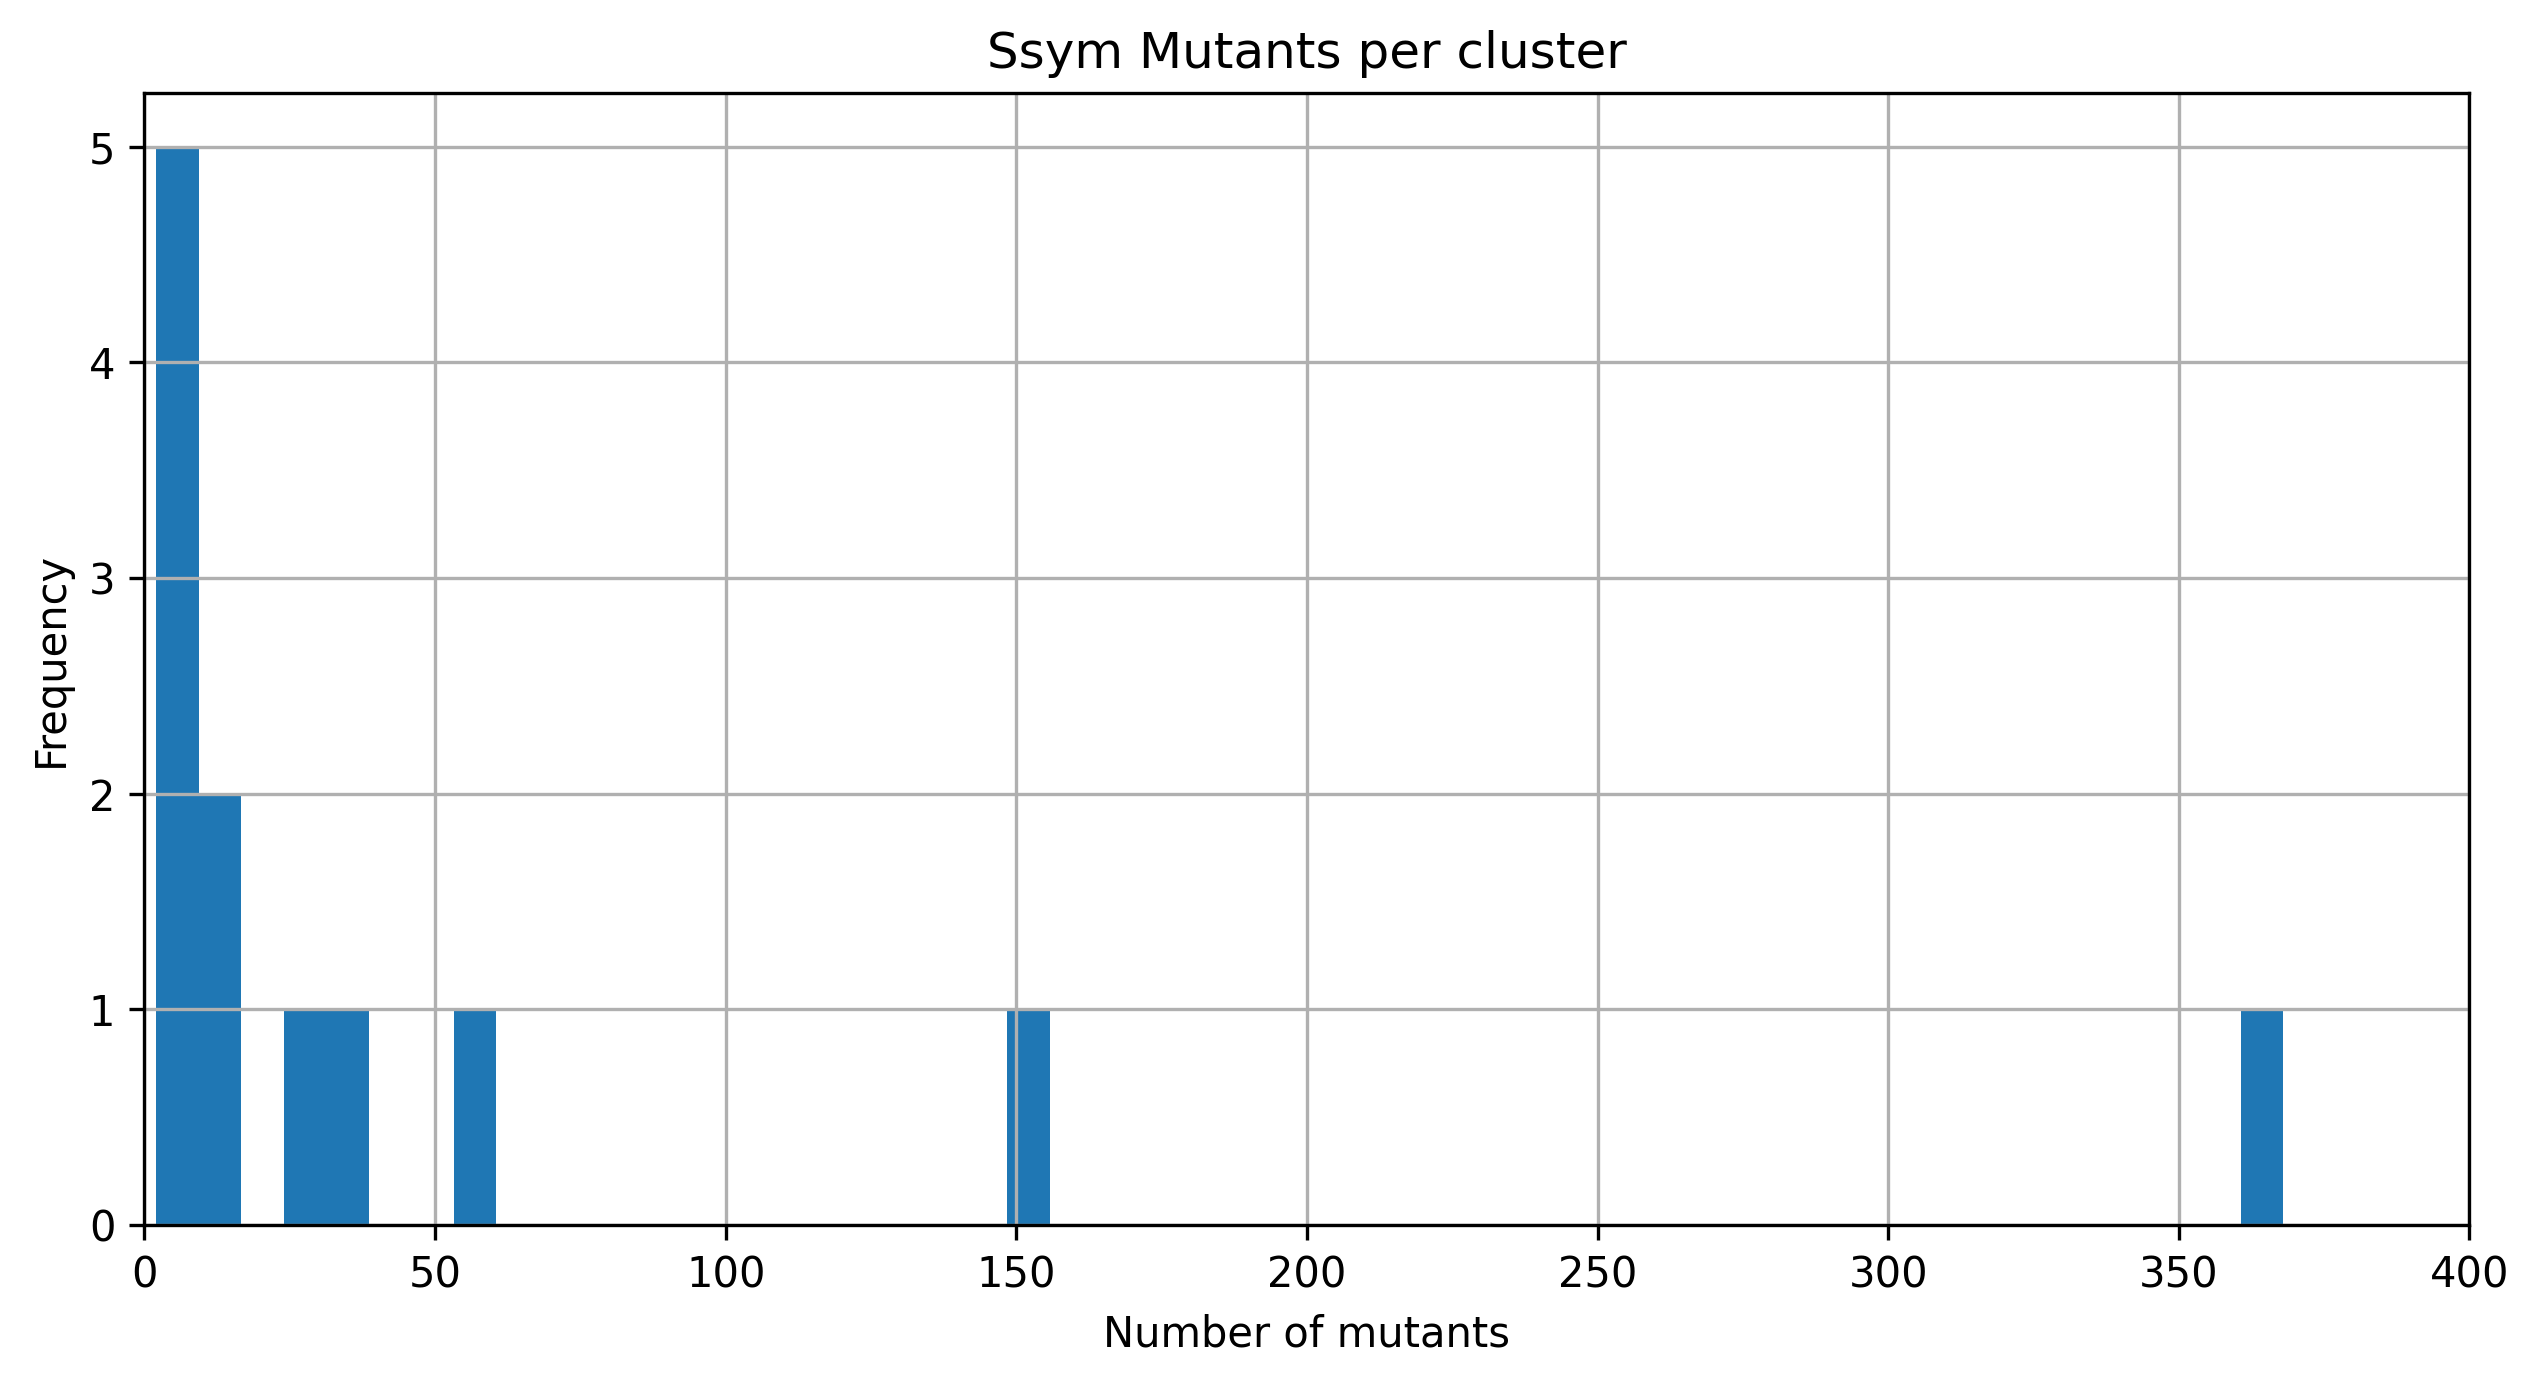

In [8]:
"""# compile predictions and measurements for statistical analysis
db_class = db_stacked_preds.reset_index().set_index('uid').join(db_ddgs_2).join(db_clusters.reset_index('uid2', drop=True)).reset_index().set_index(['direction', 'uid'])

# necessary to save this to run Q3421 ensemble modelling
preds_loc = preds_loc.replace('ssym_mapped_preds_clusters.csv', 'ssym_mapped_preds_clusters_extra.csv')
db_class.rename({'delta_vol_dir':'delta_vol', 'delta_kdh_dir':'delta_kdh', 'rel_ASA_dir': 'rel_ASA'}, axis=1).to_csv(preds_loc)"""

db_class = db_stacked_preds.reset_index()

print('Original unique mutations:', len(db_class))

original_pred_cols = [c for c in db_class.columns if  not 'runtime' in c and not 'pll' in c and not 'ddG' in c and not 'cluster' in c]
original_pred_cols_reduced = deepcopy(original_pred_cols)
for col in [f'esm1v_{i}' for i in range(1,6)]:
    original_pred_cols_reduced.remove(col)
for col in [f'msa_{i}' for i in range(1,6)]:
    original_pred_cols_reduced.remove(col)
#for col in ['esm2_15B_half_dir', 'esm2_150M_dir']:
#    original_pred_cols_reduced.remove(col)
print(original_pred_cols_reduced)

db_class = db_class[original_pred_cols_reduced + ['ddG', 'cluster']]
db_class['cluster'] = db_class['cluster'].astype(int)

evolutionary = ['tranception', 'msa_transformer', 'esm1v', 'msa', 'esm2', 'ankh']
structural = ['mpnn', 'mif', 'mifst', 'esmif']
supervised = ['MAESTRO', 'ThermoNet', 'INPS', 'PremPS', 'mCSM', 'DUET', 'ACDC', 'I-Mutant3.0', 'SAAFEC', 'MuPro']
untrained = ['DDGun']
potential = ['KORPM', 'PopMusic', 'SDM']
biophysical = ['cartesian_ddg', 'FoldX', 'Evo']

db_class_rescaled = db_class.copy(deep=True)
db_class_rescaled[original_pred_cols_reduced] /= db_class_rescaled[original_pred_cols_reduced].std()

db_class['mpnn_rosetta'] = db_class['cartesian_ddg'] + db_class['mpnn_20_00']

db_class['random'] = np.random.normal(loc=0, size=len(db_class))
db_class['korpm'] = db_class['KORPM']

fig, axes = plt.subplots(1, figsize=(10, 5), dpi=300) 
db_class.groupby('cluster').count().iloc[:, 0].hist(bins=50, ax=axes)
#db_class.groupby('cluster').count().iloc[:, 0].hist(bins=800, ax=axes[1])
plt.xlim([0,400])
plt.title('Ssym Mutants per cluster')
plt.xlabel('Number of mutants')
plt.ylabel('Frequency')

group_counts = db_class.groupby('cluster').count().iloc[:, 0]
print(group_counts)
large_groups = group_counts > 0
filtered_df = db_class[db_class['cluster'].isin(large_groups[large_groups].index)]
db_class = filtered_df

#l1 = len(db_class)
#db_class = db_class.loc[~db_feats_2['on_interface']]
#l2 = len(db_class)
#print(f'Dropped {l1-l2} interface mutations')
#db_class = db_class.loc[~db_feats_2['on_interface']]
#print(f'Dropped {l2-len(db_class)} mutations in binding regions')

print('Unique mutations in chosen set:', len(db_class))
print('Unique clusters (protein families with significant structural homology):', len(db_class['cluster'].unique()))

#db_class.to_csv('../data/Ssym_mapped_preds_clusters_extra.csv')
db_class

In [9]:
db_class.groupby('cluster').count().iloc[:, [1]]

pred_col,uid
cluster,
1,28
2,368
3,10
4,2
5,6
6,36
7,6
8,150
9,56


In [10]:
# add the "extras" file which has predictions from the Q3421-trained ensemble
#db_class = pd.read_csv('../data/inference/ssym_mapped_preds_clusters_extra.csv')
db_class = db_class.set_index(['direction', 'uid'])
db_class

pred_col              ACDC-NN  ACDC-NN-Seq  Cartddg  DDG  DDGun  DDGun3D  \
direction uid                                                              
dir       1AMQ_191F  0.155387     0.000000    -8.00 -1.6    0.9      0.9   
          1AMQ_191S -0.310174     0.000000    -4.22 -1.9    0.2     -0.5   
          1AMQ_191W  0.175478     0.000235    -8.00 -3.9    1.1      1.0   
          1AMQ_191Y  0.255306     0.007419    -7.80 -2.3    1.3      1.3   
          1BNI_14A  -1.032232    -1.280774    -8.00 -4.5   -3.1     -3.1   
...                       ...          ...      ...  ...    ...      ...   
inv       5PTI_22A   1.446976     1.744492     1.97  1.2    2.7      2.8   
          5PTI_23A   2.190413     3.002760     4.56  5.9    4.2      3.8   
          5PTI_35G   2.394038     3.046156    -0.56  5.0    4.5      3.6   
          5PTI_43G   1.418397     1.558716     3.24  5.7    2.1      1.5   
          5PTI_45A   2.607126     3.225423     8.98  6.9    5.3      3.7   

pred_col              DUET  Dynamut  Dynamut2   Evo  ...  mpnn_30_00  \
direction uid                                        ...               
dir       1AMQ_191F -0.992    0.800     -1.34 -0.43  ...   -4.185785   
          1AMQ_191S -1.717   -0.149     -2.18 -1.18  ...   -0.763924   
          1AMQ_191W -1.495    1.222     -1.75  0.24  ...   -4.321257   
          1AMQ_191Y -1.307    1.210     -1.23 -3.15  ...   -4.159512   
          1BNI_14A  -3.172   -2.526     -2.34 -2.93  ...   -4.914061   
...                    ...      ...       ...   ...  ...         ...   
inv       5PTI_22A  -0.819    0.996     -0.67  1.48  ...   -3.072806   
          5PTI_23A  -0.888    1.028     -0.72 -1.85  ...    5.011670   
          5PTI_35G  -1.774    1.082     -0.55  0.81  ...   -5.357002   
          5PTI_43G  -0.450    1.228     -0.56  1.96  ...    4.293312   
          5PTI_45A  -1.081    1.243     -0.88  2.10  ...    5.221313   

pred_col             msa_transformer_mean  msa_transformer_median  \
direction uid                                                       
dir       1AMQ_191F            -11.279768              -11.458145   
          1AMQ_191S             -5.687223               -5.619745   
          1AMQ_191W            -13.326253              -13.317976   
          1AMQ_191Y            -11.288756              -11.298208   
          1BNI_14A             -12.701860              -13.243906   
...                                   ...                     ...   
inv       5PTI_22A               8.379252                8.087660   
          5PTI_23A              12.005811               11.668735   
          5PTI_35G              10.283704               10.450047   
          5PTI_43G               9.196254                9.729218   
          5PTI_45A              12.495776               12.292369   

pred_col             mutcomputex  stability-oracle  tranception  ddG  cluster  \
direction uid                                                                   
dir       1AMQ_191F    -0.072907            -1.094    -0.030816 -1.6       10   
          1AMQ_191S     0.152491            -1.204    -0.015824 -1.9       10   
          1AMQ_191W    -0.072507            -1.124    -0.039274 -3.9       10   
          1AMQ_191Y    -0.072155            -1.136    -0.029105 -2.3       10   
          1BNI_14A     -0.994928            -3.670    -0.079214 -4.5        1   
...                          ...               ...          ...  ...      ...   
inv       5PTI_22A     -0.907782            -0.770     0.047729  1.2       11   
          5PTI_23A     -0.084975             2.360     0.104299  5.9       11   
          5PTI_35G     -0.999981            -1.340     0.091949  5.0       11   
          5PTI_43G     -0.999996            -0.437     0.055134  5.7       11   
          5PTI_45A      0.279832             1.036     0.100102  6.9       11   

pred_col             mpnn_rosetta    random  
direction uid                                
dir       1AMQ_191F     -9.940

In [11]:
# compute statistics on the results for use by later methods
class_result = analysis_utils.compute_stats_bidirectional(db_class, stats=(), grouper='cluster', stacked=True)
class_result.to_csv('../data/extended/ssym_extended.csv')

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

In [12]:
table1 = class_result #.loc[:,['n', 'MCC', 'auprc', 'spearman', 'weighted_ndcg', 'weighted_auprc', 'weighted_spearman']]
table = table1.sort_values(['direction', 'weighted_spearman'], ascending=False).reset_index()

for source, target in remap_names.items():
    table.loc[table['model']==source, 'model'] = target
#table['model'] = table['model'].map(remap_names)
table.loc[table['model'].isin(['Gaussian noise', 'ΔΔG label']), 'model_type'] = 'control'

remap_cols = {'auprc': 'AUPRC', 'spearman': 'Spearman\'s ρ', 'auppc': 'mean PPC', 'aumsc': 'mean MSC', 'weighted_ndcg': 'wNDCG', 
    'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC', 'tp': 'True Positives', 'sensitivity': 'Sensitivity', 'antisymmetry': 'Antisymmetry', 'bias': 'Bias',
    'net_stabilization': 'Net Stabilization', 'accuracy': 'Accuracy', 'pearson': 'Pearson', 'precision': 'Precision'}
table = table.rename(remap_cols, axis=1)
#table = table[['direction', 'model_type', 'model', 'n', 'MCC', 'AUPRC', 'ρ', 'wNDCG', 'wAUPRC', 'wρ', 'mean_t1s', 'Net Stabilization',
#    'mean_stabilization', 'mean PPC', 'mean MSC', 'True Positives', 'Sensitivity', 'Accuracy', 'Pearson']]
table = table.rename({'direction': 'Direction', 'model_type': 'Model Type', 'model': 'Model'}, axis=1)
table = table[['Direction', 'Model Type', 'Model', 'n', 'Spearman\'s ρ', 'Sensitivity', 'Precision', 'Antisymmetry', 'Bias']]
#table = table.loc[table['model'].isin(['PremPS'])] 
#table = table.loc[table['Model'].isin(['Rosetta CartDDG', 'ProteinMPNN mean', 'ProteinMPNN 30', 'ProteinMPNN 20', 'ESM-IF', 'MIF', 'ESM-IF(M)', 'Ankh', 'MutComputeX',
#    'ESM-2 3B', 'ESM-2 15B', 'ESM-2 150M', 'ESM-2 650M', #'ESM-2 mean', 'ESM-IF mean', 'MIF mean', 'Clustered Ensemble', 'Ensemble 2', 'ESM-1V 2', 'MSA-T 1', 'Structural', 'Evolutionary', 'Supervised'
#    'ProteinMPNN 10', 'MIF-ST', 'KORPM', 'MSA-T mean', 'Tranception', 'ESM-1V mean', 'Stability Oracle', 'Ankh', 'MAESTRO', 'ThermoNet', 'ACDC-NN', 'ACDC-NN-Seq', 'PremPS',
#    'PoPMuSiC', 'SDM', 'FoldX', 'Evo', 'INPS3D', 'INPS-Seq', 'DDGun', 'DDGun3D', 'I-Mutant3.0', 'I-Mutant3.0-Seq', 'SAAFEC-SEQ', 'MUPro', 'mCSM', 'DUET', 'Dynamut2',
#     'Gaussian noise', 'ΔΔG label', 'ProteinMPNN + Rosetta CartDDG'])]
table = table.loc[~table['Model'].str.contains('q3421')]
table = table.dropna(subset='Model').set_index(['Direction', 'Model Type', 'Model']).astype(float).round(3).drop_duplicates()

table.xs('combined').sort_values('Spearman\'s ρ', ascending=False)

n  Spearman's ρ  Sensitivity  Precision  \
Model Type   Model                                                           
control      ΔΔG label         684.0         1.000        1.000      1.000   
NaN          DDG               684.0         0.968        0.953      0.976   
supervised   PremPS            684.0         0.839        0.845      0.814   
ensemble     Rosetta/ProtMPNN  684.0         0.744        0.646      0.888   
potential    KORPM             684.0         0.715        0.772      0.786   
structural   ProteinMPNN 0.3   684.0         0.696        0.731      0.806   
             ProteinMPNN 0.2   684.0         0.690        0.690      0.828   
biophysical  Rosetta CartDDG   684.0         0.665        0.614      0.827   
structural   ProteinMPNN 0.1   684.0         0.648        0.640      0.820   
NaN          Cartddg           684.0         0.628        0.579      0.825   
transfer     ACDC-NN           684.0         0.620        0.699      0.701   
evolutionary MSA-T mean        684.0         0.611        0.734      0.734   
             MSA-T median      684.0         0.608        0.746      0.746   
transfer     Stability Oracle  683.0         0.606        0.619      0.844   
structural   MIF-ST            684.0         0.604        0.675      0.755   
evolutionary ESM-2 15B         684.0         0.600        0.737      0.737   
structural   MIF               684.0         0.591        0.564      0.788   
evolutionary ESM-2 650M        684.0         0.585        0.728      0.728   
             Ankh              684.0         0.579        0.725      0.725   
             Tranception       684.0         0.575        0.731      0.731   
             ESM-2 3B          684.0         0.574        0.734      0.734   
transfer     ACDC-NN-Seq       684.0         0.568        0.576      0.694   
structural   ESM-IF(M)         684.0         0.553        0.558      0.758   
             ESM-IF            684.0         0.552        0.558      0.755   
untrained    DDGun3D           684.0         0.547        0.646      0.695   
             DDGun             684.0         0.542        0.649      0.679   
supervised   INPS-Seq          684.0         0.542        0.646      0.654   
biophysical  FoldX             684.0         0.514        0.602      0.720   
             Evo               684.0         0.480        0.611      0.672   
potential    PoPMuSiC          684.0         0.471        0.275      0.832   
structural   MutComputeX       684.0         0.470        0.427      0.874   
supervised   INPS3D            684.0         0.460        0.371      0.770   
unknown      Dynamut           684.0         0.454        0.681      0.687   
evolutionary ESM-1V mean       684.0         0.454        0.664      0.664   
             ESM-1V median     684.0         0.451        0.661      0.661   
             ESM-2 150M        684.0         0.450        0.673      0.673   
supervised   ThermoNet         678.0         0.415        0.623      0.618   
             I-Mutant3.0-Seq   682.0         0.407        0.273      0.823   
             MAESTRO           684.0         0.402        0.234      0.777   
             DUET              684.0         0.381        0.339      0.748   
             I-Mutant3.0       682.0         0.363        0.290      0.733   
             MUpro             684.0         0.358        0.225      0.819   
             mCSM              684.0         0.328        0.126      0.741   
potential    SDM               684.0         0.298        0.471      0.679   
unknown      Dynamut2          684.0         0.286        0.211      0.649   
supervised   SAAFEC-SEQ        684.0         0.192        0.164      0.700   
unknown      Gaussian Noise    684.0        -0.022        0.474      0.482   

                               Antisymmetry   Bias  
Model Type   Model                                  
control      ΔΔG label               -1.000  0.000  
NaN          DDG                     -1.000  0.000  


In [13]:
db_class_ = db_class.copy(deep=True)
new_index = db_class_.reset_index()
new_index = new_index['uid'] + '_' + new_index['direction']
db_class_.index = new_index
db_class_.columns = [c+'_dir' for c in db_class_.columns]
db_class_ = db_class_.rename({'cluster_dir': 'cluster'}, axis=1)
db_class_['ddG'] = db_class_['ddG_dir']
db_class_['code'] = db_class_.index.str[:4]
db_class_

,ACDC-NN_dir,ACDC-NN-Seq_dir,Cartddg_dir,DDG_dir,DDGun_dir,DDGun3D_dir,DUET_dir,Dynamut_dir,Dynamut2_dir,Evo_dir,...,msa_transformer_median_dir,mutcomputex_dir,stability-oracle_dir,tranception_dir,ddG_dir,cluster,mpnn_rosetta_dir,random_dir,ddG,code
1AMQ_191F_dir,0.155387,0.000000,-8.00,-1.6,0.9,0.9,-0.992,0.800,-1.34,-0.43,...,-11.458145,-0.072907,-1.094,-0.030816,-1.6,10,-9.940203,-0.212999,-1.6,1AMQ
1AMQ_191S_dir,-0.310174,0.000000,-4.22,-1.9,0.2,-0.5,-1.717,-0.149,-2.18,-1.18,...,-5.619745,0.152491,-1.204,-0.015824,-1.9,10,-5.129149,-0.882922,-1.9,1AMQ
1AMQ_191W_dir,0.175478,0.000235,-8.00,-3.9,1.1,1.0,-1.495,1.222,-1.75,0.24,...,-13.317976,-0.072507,-1.124,-0.039274,-3.9,10,-21.056967,-0.144470,-3.9,1AMQ
1AMQ_191Y_dir,0.255306,0.007419,-7.80,-2.3,1.3,1.3,-1.307,1.210,-1.23,-3.15,...,-11.298208,-0.072155,-1.136,-0.029105,-2.3,10,-11.157171,1.685126,-2.3,1AMQ
1BNI_14A_dir,-1.032232,-1.280774,-8.00,-4.5,-3.1,-3.1,-3.172,-2.526,-2.34,-2.93,...,-13.243906,-0.994928,-3.670,-0.079214,-4.5,1,-14.114356,-0.760150,-4.5,1BNI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5PTI_22A_inv,1.446976,1.744492,1.97,1.2,2.7,2.8,-0.819,0.996,-0.67,1.48,...,8.087660,-0.907782,-0.770,0.047729,1.2,11,2.231657,-0.523183,1.2,5PTI
5PTI_23A_inv,2.190413,3.002760,4.56,5.9,4.2,3.8,-0.888,1.028,-0.72,-1.85,...,11.668735,-0.084975,2.360,0.104299,5.9,11,11.405331,1.636057,5.9,5PTI
5PTI_35G_inv,2.394038,3.046156,-0.56,5.0,4.5,3.6,-1.774,1.082,-0.55,0.81,...,10.450047,-0.999981,-1.340,0.091949,5.0,11,-4.590325,-0.441652,5.0,5PTI
5PTI_43G_inv,1.418397,1.558716,3.24,5.7,2.1,1.5,-0.450,1.228,-0.56,1.96,...,9.729218,-0.999996,-0.437,0.055134,5.7,11,15.060090,-0.276564,5.7,5PTI


In [14]:
summ = analysis_utils.compute_stats(db_class_.drop('code', axis=1), 
                                    stats=('n', 'MCC', 'pred_positives', 'tp', 'auprc', 'spearman', 'ndcg', 'mean_t1s', 'mean_stabilization', 'net_stabilization', 'sensitivity', 'recall@k0.0', 'recall@k1.0', 'mean_reciprocal_rank', 'fractional_gain', 'precision'), 
                                    measurements=['ddG'], grouper='cluster', n_classes=2, n_bootstraps=100, quiet=True)
tmp1 = summ.reset_index()
tmp1.to_csv('../data/extended/ssym_extended_bootstrapped.csv')

In [15]:
importlib.reload(analysis_utils)
remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

remap_cols = {'auprc': 'AUPRC', 'spearman': 'Spearman\'s ρ', 'auppc': 'mean PPC', 'aumsc': 'mean MSC', 'weighted_ndcg': 'wNDCG', 'ndcg': 'NDCG',
    'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC', 'tp': 'True Positives', 'sensitivity': 'Sensitivity', 'mean_stabilization': 'Mean Stabilization',
    'net_stabilization': 'Net Stabilization', 'accuracy': 'Accuracy', 'mean_reciprocal_rank': 'MRR', 'n': 'n', 'MCC': 'MCC', 'recall@k1.0': 'Recall @ k'}

new_remap_cols = {}
for key, value in remap_cols.items():
    new_remap_cols[key + '_mean'] = value + ' mean'
    new_remap_cols[key + '_std'] = value + ' stdev'

s2 = summ.sort_values('net_stabilization_mean', ascending=False).dropna(how='all', axis=1).reset_index()
s3 = s2.loc[s2['model'].isin([c+'_dir' for c in original_pred_cols_reduced] + [
            'random_dir', 
            'ddG_dir', 
            'q3421_pslm_rfa_2_dir', 
            'q3421_pslm_rfa_3_dir', 
            'q3421_pslm_rfa_4_dir',
            'q3421_pslm_rfa_5_dir',
            'mpnn_rosetta_dir'])
            ].drop('measurement', axis=1)
s4 = s3[['model_type', 'model',
    'recall@k1.0_mean', 'recall@k1.0_std',
    'ndcg_mean', 'ndcg_std', 
    'spearman_mean', 'spearman_std',
    'auprc_mean', 'auprc_std', 
    'MCC_mean', 'MCC_std', 
    'net_stabilization_mean', 'net_stabilization_std',
    ]]
s4['model'] = s4['model'].map(lambda x: remap_names_2.get(x, x[:-4]))
s5 = s4.set_index(['model_type', 'model'])
s5.columns = [new_remap_cols[c] for c in s5.columns]
s5
# Iterate over the DataFrame and update the mean columns
for column in s5.columns:
    if 'mean' in column:
        stdev_column = column.replace('mean', 'stdev')
        s5[column] = s5[column].round(3).astype(str) + ' ± ' + s5[stdev_column].round(2).astype(str)

# Drop the standard deviation columns
s5 = s5[[col for col in s5.columns if 'stdev' not in col]]
s5.columns = [col[:-5] for col in s5.columns]
s6 = s5.reset_index().rename({'model_type': 'Model Type', 'model': 'Model'}, axis=1)
s6.drop_duplicates()

,Model Type,Model,Recall @ k,NDCG,Spearman's ρ,AUPRC,MCC,Net Stabilization
0,unknown,ΔΔG label,1.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,959.462 ± 739.63
1,NaN,DDG,0.923 ± 0.05,0.995 ± 0.01,0.966 ± 0.03,0.975 ± 0.02,0.936 ± 0.04,940.626 ± 727.24
2,supervised,PremPS,0.774 ± 0.03,0.931 ± 0.01,0.83 ± 0.07,0.912 ± 0.03,0.65 ± 0.07,811.649 ± 650.16
3,evolutionary,MSA-T median,0.564 ± 0.1,0.849 ± 0.04,0.565 ± 0.2,0.741 ± 0.08,0.448 ± 0.15,722.035 ± 651.22
4,evolutionary,MSA-T mean,0.567 ± 0.1,0.853 ± 0.04,0.566 ± 0.2,0.74 ± 0.08,0.429 ± 0.14,716.64 ± 644.32
5,potential,KORPM,0.573 ± 0.08,0.849 ± 0.04,0.671 ± 0.12,0.845 ± 0.05,0.542 ± 0.07,713.484 ± 621.42
7,structural,ProteinMPNN 0.3,0.63 ± 0.07,0.854 ± 0.05,0.64 ± 0.15,0.816 ± 0.08,0.528 ± 0.09,709.234 ± 631.9
8,evolutionary,Ankh,0.537 ± 0.12,0.801 ± 0.07,0.509 ± 0.22,0.701 ± 0.09,0.407 ± 0.16,705.178 ± 643.86
9,evolutionary,ESM-2 3B,0.493 ± 0.1,0.805 ± 0.05,0.508 ± 0.19,0.718 ± 0.08,0.425 ± 0.14,701.18 ± 655.71
10,evolutionary,ESM-2 15B,0.524 ± 0.11,0.829 ± 0.06,0.529 ± 0.2,0.74 ± 0.09,0.425 ± 0.17,697.33 ± 656.05


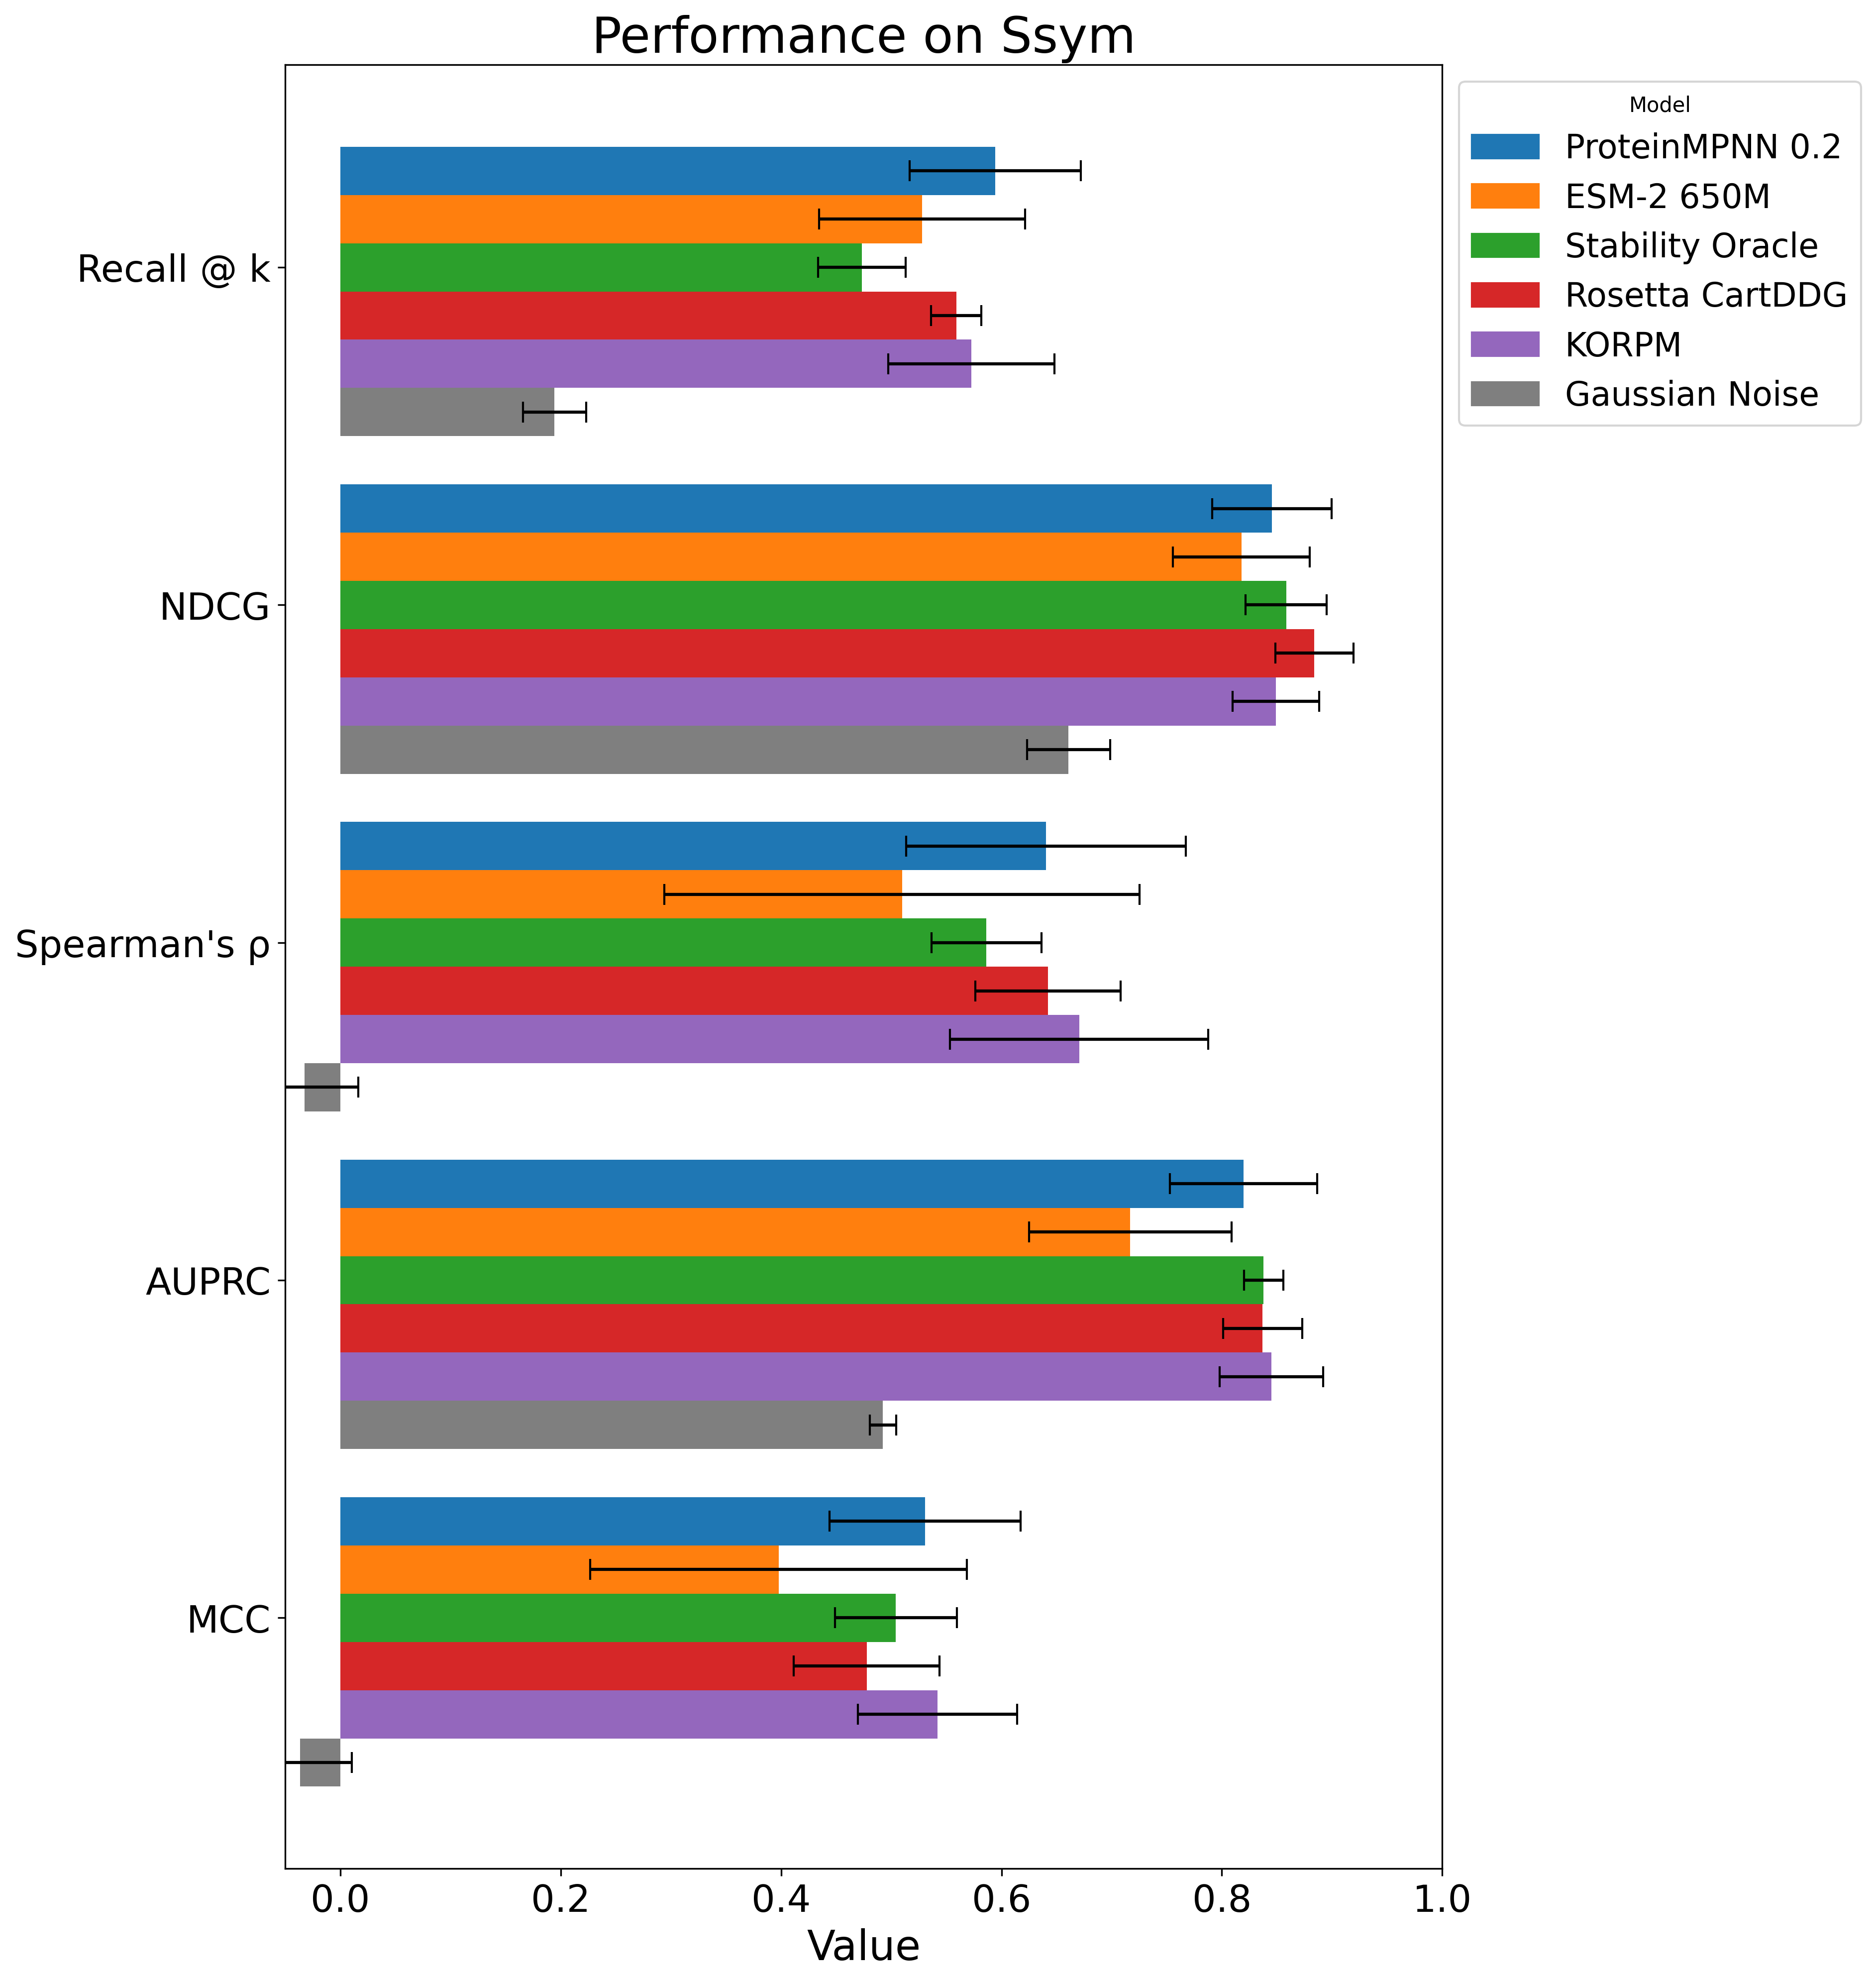

In [16]:
import importlib
importlib.reload(analysis_utils)

remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

tmp3 = tmp1.copy(deep=True)#.set_index('model')
#tmp3['fractional_gain_mean'] = tmp3['net_stabilization_mean'] / tmp3.at['ddG_dir', 'net_stabilization_mean']
#tmp3['fractional_gain_std'] = tmp3['net_stabilization_std'] / tmp3.at['ddG_dir', 'net_stabilization_mean']
#tmp3 = tmp3.reset_index()
#tmp3['fractional_gain_mean']

remap_cols = {'auprc': 'AUPRC', 'spearman': 'Spearman\'s ρ', 'auppc': 'mean PPC', 'aumsc': 'mean MSC', 'weighted_ndcg': 'wNDCG', 'ndcg': 'NDCG',
    'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC', 'tp': 'True Positives', 'sensitivity': 'Sensitivity', 'mean_stabilization': 'Mean Stabilization',
    'net_stabilization': 'Net Stabilization', 'accuracy': 'Accuracy', 'mean_reciprocal_rank': 'MRR', 'n': 'n', 'MCC': 'MCC', 'recall@k1.0': 'Recall @ k'}

new_remap_cols = {}
for key, value in remap_cols.items():
    new_remap_cols[key + '_mean'] = value + ' mean'
    new_remap_cols[key + '_std'] = value + ' stdev'

s2 = tmp3.sort_values('spearman_mean', ascending=False).dropna(how='all', axis=1).reset_index()

s4 = s2.loc[s2['model'].isin([c+'_dir' for c in original_pred_cols_reduced] + ['random_dir', 'ddG_dir', 'mpnn_rosetta_dir'])]
#s4 = s3[['model', 'n_mean', 'MCC_mean', 'MCC_std', 'auprc_mean', 'auprc_std', 'spearman_mean', 'spearman_std', 'weighted_ndcg_mean', 'weighted_ndcg_std', 'recall@k1.0_mean', 'recall@k1.0_std', 'mean_stabilization_mean', 'mean_stabilization_std']]
#s4['model'] = s4['model'].map(lambda x: remap_names_2.get(x, x[:-4]))
s5 = s4

tmp2 = s5[[ 'model',  
            'MCC_mean', 'MCC_std',
            'auprc_mean', 'auprc_std',
            #'weighted_spearman_mean', 'weighted_spearman_std',
            'spearman_mean', 'spearman_std',
            #'weighted_ndcg_mean', 'weighted_ndcg_std',
            'ndcg_mean', 'ndcg_std',
            'recall@k1.0_mean', 'recall@k1.0_std', 
            ]].set_index('model')

tmp2.columns = [new_remap_cols[c] for c in tmp2.columns]
tmp2 = tmp2.reset_index().drop_duplicates()

#analysis_utils.make_bar_chart(tmp2, models=['ProteinMPNN 0.2', 'ESM-2 650M', 'Stability Oracle', 'Rosetta CartDDG', 'KORPM', 'DDGun3D', 'MAESTRO', 'Gaussian Noise'], title='Q3421', xlim=(-0.5, 0.8), figsize=(24, 16))
analysis_utils.make_bar_chart(tmp2, models=['mpnn_20_00', 'esm2_650M', 'stability-oracle', 'cartesian_ddg', 'KORPM', 'random'], title='Ssym', xlim=(-0.05, 1), figsize=(10, 16))

In [17]:
zs_feats = ['delta_kdh', 'delta_vol', 'rel_ASA']
#red_cols = [c[:-4] for c in original_pred_cols_reduced]

#models = original_pred_cols_reduced + [c + '_dir' for c in zs_feats]
#models += [c.replace('_dir', '_inv') for c in models]
#print(models)
models = list(db_class.columns)

db_ens = db_class.copy(deep=True)
db_ens = db_ens[models]

print(len(db_ens))
db_ens['random'] = np.random.rand(len(db_ens)) - 0.5
#db_ens['random_inv'] = np.random.rand(len(db_ens)) - 0.5
#db_ens = db_ens.drop(['KORPMD_dir', 'CartddgD_dir', 'FoldXD_dir', 'EvoD_dir', 'Dyna2D_dir', 'PopMsD_dir', 'DDGunD_dir', 'TNetD_dir', 'ACDCNND_dir'], axis=1)
dfm = db_ens.copy(deep=True)

def unstack_frames(df):
    df_dir = df.xs('dir')
    df_dir.columns = [c + '_dir' for c in df_dir.columns]
    df_inv = df.xs('inv')
    df_inv.columns = [c + '_inv' for c in df_inv.columns]
    return df_dir.join(df_inv)
dfu = unstack_frames(dfm)

weights = [1, 0.5, 0.2]
#weights2 = [0.8, 0.3]

all_cols = []

tmp = []
for model1 in models:
    for model2 in models:
        if model1 != model2: #(model1.split('_')[0] != model2.split('_')[0]) and (model1[:4] != model2[:4]) and
            for weight in weights:
                tmp.append(pd.Series(dfm[model1]/dfm[model1].std() + dfm[model2]/dfm[model2].std() * weight, name=f'{model1} + {model2} * {weight}'))
                all_cols.append(f'{model1} + {model2} * {weight}')
                #for model3 in models:
                #    if model2 != model3 and model1 != model3:
                #        for weight2 in weights2:
                #            tmp.append(pd.Series(dfm[model1] + dfm[model2] * weight + dfm[model3] * weight2, name=f'{model1} + {model2} * {weight} + {model3} * {weight2}'))
                #            all_cols.append(f'{model1} + {model2} * {weight} + {model3} * {weight2}')

dfm = pd.concat([dfm] + tmp, axis=1)
#dfm = dfm.join(db_stacked_runtimes)
dfm
#dfm.to_csv(os.path.join(path, 'results', 'ensemble_s461_2_models_3_weights_preds.csv'))
#dfm

684


ACDC-NN  ACDC-NN-Seq  Cartddg  DDG  DDGun  DDGun3D  \
direction uid                                                              
dir       1AMQ_191F  0.155387     0.000000    -8.00 -1.6    0.9      0.9   
          1AMQ_191S -0.310174     0.000000    -4.22 -1.9    0.2     -0.5   
          1AMQ_191W  0.175478     0.000235    -8.00 -3.9    1.1      1.0   
          1AMQ_191Y  0.255306     0.007419    -7.80 -2.3    1.3      1.3   
          1BNI_14A  -1.032232    -1.280774    -8.00 -4.5   -3.1     -3.1   
...                       ...          ...      ...  ...    ...      ...   
inv       5PTI_22A   1.446976     1.744492     1.97  1.2    2.7      2.8   
          5PTI_23A   2.190413     3.002760     4.56  5.9    4.2      3.8   
          5PTI_35G   2.394038     3.046156    -0.56  5.0    4.5      3.6   
          5PTI_43G   1.418397     1.558716     3.24  5.7    2.1      1.5   
          5PTI_45A   2.607126     3.225423     8.98  6.9    5.3      3.7   

                      DUET  Dynamut  Dynamut2   Evo  ...  \
direction uid                                        ...   
dir       1AMQ_191F -0.992    0.800     -1.34 -0.43  ...   
          1AMQ_191S -1.717   -0.149     -2.18 -1.18  ...   
          1AMQ_191W -1.495    1.222     -1.75  0.24  ...   
          1AMQ_191Y -1.307    1.210     -1.23 -3.15  ...   
          1BNI_14A  -3.172   -2.526     -2.34 -2.93  ...   
...                    ...      ...       ...   ...  ...   
inv       5PTI_22A  -0.819    0.996     -0.67  1.48  ...   
          5PTI_23A  -0.888    1.028     -0.72 -1.85  ...   
          5PTI_35G  -1.774    1.082     -0.55  0.81  ...   
          5PTI_43G  -0.450    1.228     -0.56  1.96  ...   
          5PTI_45A  -1.081    1.243     -0.88  2.10  ...   

                     random + tranception * 0.2  random + ddG * 1  \
direction uid                                                       
dir       1AMQ_191F                    1.047562          0.300094   
          1AMQ_191S                   -0.165012         -1.138398   
          1AMQ_191W                   -1.213305         -3.183256   
          1AMQ_191Y                    0.141152         -0.996073   
          1BNI_14A                    -2.074916         -4.207965   
...                                         ...               ...   
inv       5PTI_22A                    -0.042810          0.416142   
          5PTI_23A                    -0.221594          2.573248   
          5PTI_35G                    -0.439025          1.914785   
          5PTI_43G                    -0.301838          2.586685   
          5PTI_45A                    -0.517520          2.841352   

                     random + ddG * 0.5  random + ddG * 0.2  \
direction uid                                                 
dir       1AMQ_191F            0.737454            0.999870   
          1AMQ_191S           -0.619033           -0.307414   
          1AMQ_191W           -2.117191           -1.477553   
          1AMQ_191Y           -0.367368            0.009855   
          1BNI_14A            -2.977890           -2.239845   
...                                 ...                 ...   
inv       5PTI_22A             0.088122           -0.108690   
          5PTI_23A             0.960484           -0.007175   
          5PTI_35G             0.548035           -0.272014   
          5PTI_43G             1.028590            0.093733   
          5PTI_45A             0.955238           -0.176431   

                     random + cluster * 1  random + cluster * 0.5  \
direction uid                                                       
dir       1AMQ_191F              4.381072                2.777943   
          1AMQ_191S              3.106591                1.503462   
          1AMQ_191W              2.155132                0.552003   
          1AMQ_191Y              3.467596                1.864466   
          1BNI_14A              -1.427189               -1.587502   
...                                   ...          

In [18]:
def get_summary_df(db_complete, cols=None, saveloc=os.path.join(path, 'results', 'ensemble_s461_2_models_3_weights_results.csv'), stats=(), stacked=False):

    assert os.path.exists(os.path.dirname(saveloc))
    #assert not os.path.exists(saveloc)
    #if cols is None:
    #    cols = db_complete.columns.drop(['code'])#, 'ddG_dir', 'ddG_inv'])

    if not stacked:
        db_stacked = analysis_utils.stack_frames(db_complete)
    else:
        db_stacked = db_complete
    #db_stacked['code'] = list(db_stacked.reset_index()['uid'].str[:4])
    #print(db_stacked)

    df_summ = analysis_utils.compute_stats_bidirectional(db_stacked, stacked=True, stats=(), grouper='cluster', directions=['dir', 'inv']).reset_index().set_index(['direction', 'model'])#.join(df_reg) #.drop('n_total', axis=1))
    df_summ = df_summ.reset_index().rename({'index': 'model'}, axis=1).set_index(['direction', 'model_type', 'model', 'class'])
    df_summ = df_summ.sort_index(level=1).sort_index(level=0)#.drop_duplicates()
    df_summ.to_csv(saveloc)
    return df_summ

In [19]:
# takes a long time to compute and has already been done
d1 = get_summary_df(dfm, saveloc=os.path.join(path, 'data', 'pairwise', 'pairwise_ssym_combinations_3_weights_new.csv'), stats=(), stacked=True) 

#d1 = pd.read_csv(os.path.join(path, 'data', 'pairwise', 'pairwise_ssym_combinations_3_weights.csv')).set_index(['direction', 'model_type', 'model', 'class'])

  0%|          | 0/7104 [00:00<?, ?it/s]

  0%|          | 0/7104 [00:00<?, ?it/s]

In [20]:
dfu_ = dfu.join(db_stacked_runtimes)
dfu_

ACDC-NN_dir  ACDC-NN-Seq_dir  Cartddg_dir  DDG_dir  \
direction uid                                                             
dir       1AMQ_191F     0.155387         0.000000        -8.00     -1.6   
          1AMQ_191S    -0.310174         0.000000        -4.22     -1.9   
          1AMQ_191W     0.175478         0.000235        -8.00     -3.9   
          1AMQ_191Y     0.255306         0.007419        -7.80     -2.3   
          1BNI_14A     -1.032232        -1.280774        -8.00     -4.5   
...                          ...              ...          ...      ...   
inv       5PTI_22A     -1.802440        -1.794489        -6.23     -1.2   
          5PTI_23A     -3.107841        -2.997760        -8.00     -5.9   
          5PTI_35G     -3.815977        -3.124952        -8.00     -5.0   
          5PTI_43G     -1.785572        -1.548846        -8.00     -5.7   
          5PTI_45A     -3.439780        -3.219905        -8.00     -6.9   

                     DDGun_dir  DDGun3D_dir  DUET_dir  Dynamut_dir  \
direction uid                                                        
dir       1AMQ_191F        0.9          0.9    -0.992        0.800   
          1AMQ_191S        0.2         -0.5    -1.717       -0.149   
          1AMQ_191W        1.1          1.0    -1.495        1.222   
          1AMQ_191Y        1.3          1.3    -1.307        1.210   
          1BNI_14A        -3.1         -3.1    -3.172       -2.526   
...                        ...          ...       ...          ...   
inv       5PTI_22A        -2.6         -2.5    -3.573       -1.876   
          5PTI_23A        -4.2         -4.0    -3.980       -3.729   
          5PTI_35G        -4.5         -4.4    -4.156       -3.250   
          5PTI_43G        -2.1         -1.9    -2.580       -1.420   
          5PTI_45A        -5.3         -4.4    -3.734       -3.474   

                     Dynamut2_dir  Evo_dir  ...  runtime_mpnn_20_00  \
direction uid                               ...                       
dir       1AMQ_191F         -1.34    -0.43  ...            0.016232   
          1AMQ_191S         -2.18    -1.18  ...            0.014761   
          1AMQ_191W         -1.75     0.24  ...            0.014751   
          1AMQ_191Y         -1.23    -3.15  ...            0.015225   
          1BNI_14A          -2.34    -2.93  ...            0.008188   
...                           ...      ...  ...                 ...   
inv       5PTI_22A          -3.01    -3.13  ...            0.008387   
          5PTI_23A          -3.86    -3.57  ...            0.007620   
          5PTI_35G          -3.94    -4.04  ...            0.007639   
          5PTI_43G          -3.05    -3.00  ...            0.008101   
          5PTI_45A          -3.22    -3.35  ...            0.007606   

                     runtime_mpnn_30_00  runtime_msa_1  runtime_msa_2  \
direction uid                                                           
dir       1AMQ_191F            0.016989       3.390493       3.497325   
          1AMQ_191S            0.016065       3.393482       3.394148   
          1AMQ_191W            0.016062       3.393750       3.387580   
          1AMQ_191Y            0.016026       3.397354       3.391266   
          1BNI_14A             0.008603       1.350701       1.348936   
...                                 ...            ...            ...   
inv       5PTI_22A             0.007817       0.882186       0.882716   
          5PTI_23A             0.007565       1.026886       0.895081   
          5PTI_35G             0.007818       0.881158       0.881511   
          5PTI_43G             0.008260       0.881816       0.880770   
          5PTI_45A             0.007539       0.881755       0.881217   

                     runtime_msa_3  runtime_msa_4  runtime_msa_5  \
direction uid                                                      
dir       1AMQ_191F       3.481303       3.485137       3.457739   
          1AMQ_191S       3.398332       3.395951       

KeyError: 'runtime_korpm'

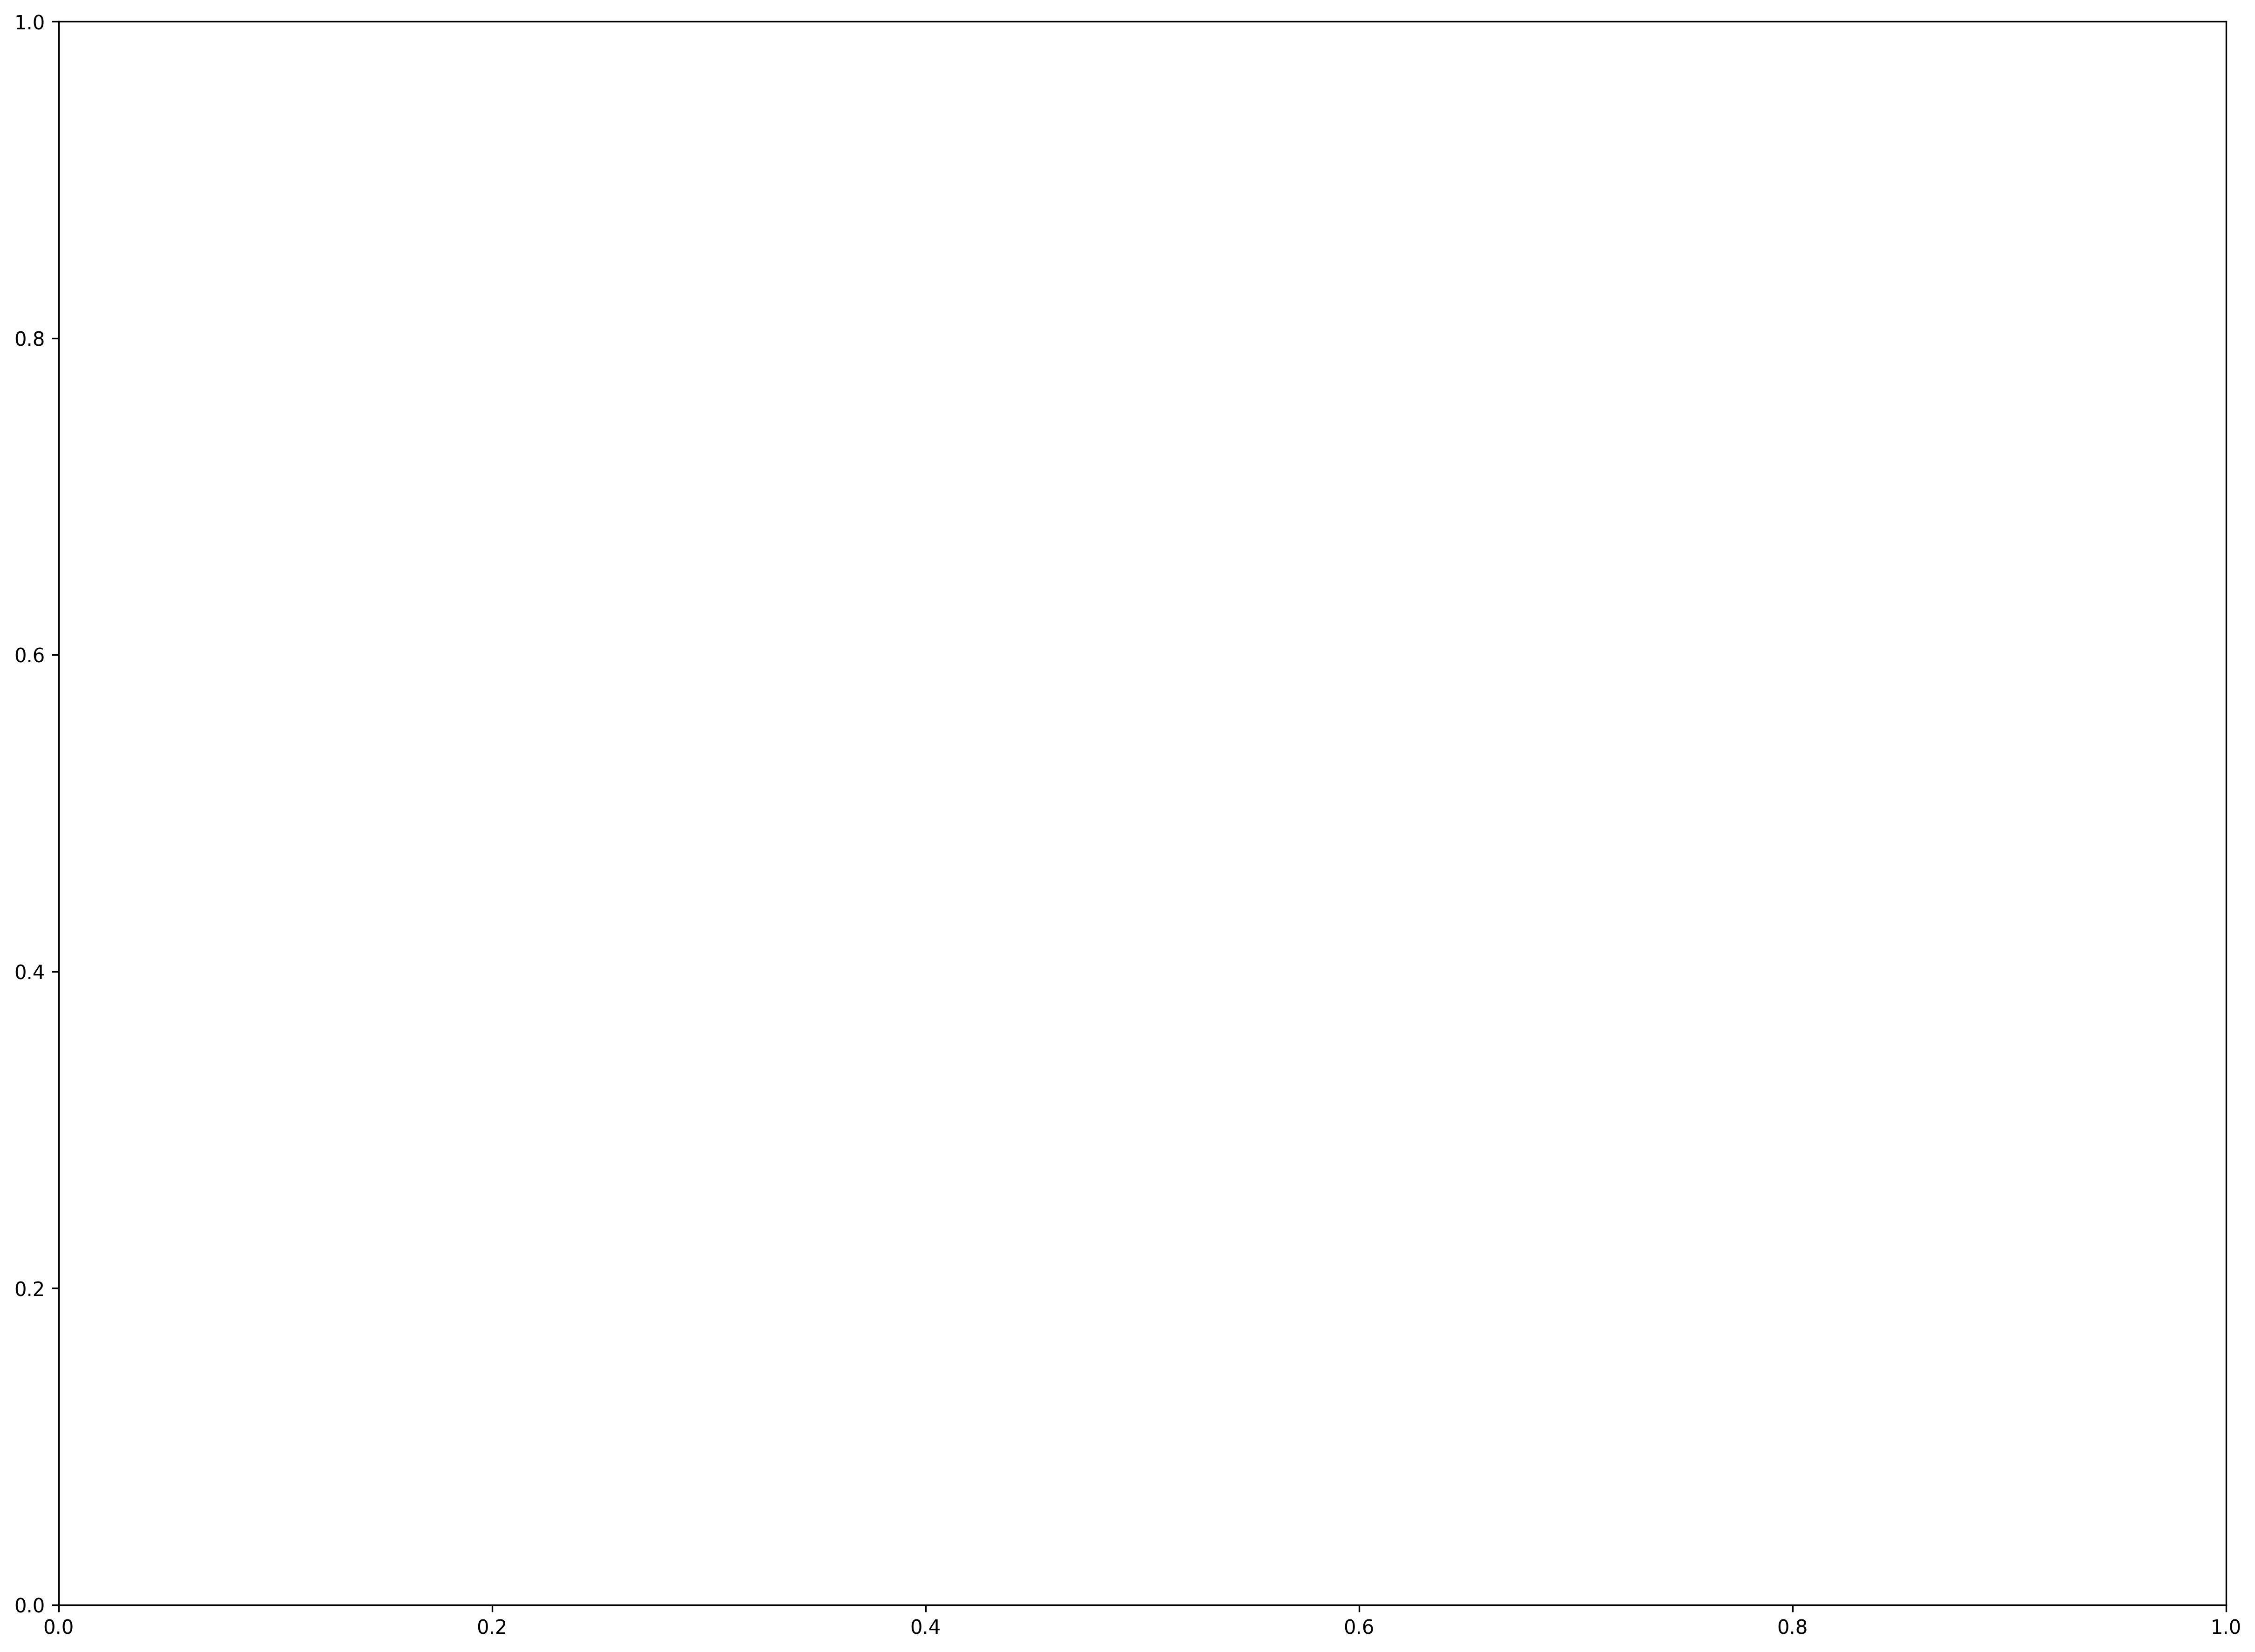

In [21]:
importlib.reload(analysis_utils)
subset = [#'ACDC-NN-Seq', 
        'ACDC-NN', 
        #'DDGun'
        'DDGun3D',
        'DUET',
        'Dynamut2',
        'FoldX',
        'Evo',
        'I-Mutant3.0',
        #'I-Mutant3.0-Seq',
        #'INPS-Seq',
        'INPS3D',
        'MAESTRO',
        'MUpro',
        'PopMusic',
        #'PremPS',
        'ThermoNet',
        'SAAFEC-Seq',
        'SDM',
        #'SOL_ACC',
        #'delta_kdh',
        #'delta_vol',
        #'abs_ASA',
        'ThermoNet',
        'mCSM',
        'cartesian_ddg',
        'esm1v_mean',
        #'esm2_mean',
        'esm2_3B',
        'ankh',
        'msa_transformer_mean',
        'tranception',
        #'esmif_monomer',
        'esmif_multimer',
        'KORPM',
        'mpnn_20_00',
        'mif',
        'mifst',
        #'mpnn_mean',
        #'esmif_mean',
        #'mif_mean',
        'stability-oracle',
        'mutcomputex']

direction = 'combined'
statistic = 'spearman'
upper = 'delta'

d2 = d1.copy(deep=True)

stat_df = analysis_utils.model_combinations_heatmap_2(d2, dfu_, statistic, direction, upper, subset=subset, annot=False, title='Ssym')
stat_df = stat_df.drop_duplicates(subset=[statistic]).reset_index(drop=True).sort_values(statistic, ascending=False).reset_index(drop=True).reset_index()

stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models = set(list(out['model1']) + list(out['model2']))
print(models)
stat_df

In [ ]:
stat_df_ = stat_df.applymap(lambda x: np.nan if x==-0.0001 else x)
stat_df_ = stat_df.applymap(lambda x: round(x, 2) if type(x)==float else x)
for source, target in remap_names.items():
    stat_df_.loc[stat_df_['model1']==source, 'model1'] = target
    stat_df_.loc[stat_df_['model2']==source, 'model2'] = target
stat_df_ = stat_df_.reset_index().drop('weight1', axis=1).rename({'rank': 'Rank', 'model1': 'Base model', 'model2': 'Added Model', 'weight2': 'Weight', 'corr': 'Model Correlation', 'runtime_cpu': 'CPU time (s)', 'runtime_gpu': 'GPU time (s)', 'spearman': 'Spearman\'s rho'}, axis=1)
#stat_df_.to_csv('../data/stat_df_ssym.csv')
stat_df_.head(30)

,Rank,Base model,Added Model,Weight,Spearman's rho,Model Correlation,CPU time (s),GPU time (s)
0,1,KORPM,ProteinMPNN 0.2,0.5,0.76,0.71,1.03,6.11
1,2,ACDC-NN,ProteinMPNN 0.2,1.0,0.76,0.58,-0.00,6.11
2,3,KORPM,Rosetta CartDDG,1.0,0.75,0.66,1.03,-0.00
3,4,Rosetta CartDDG,ProteinMPNN 0.2,1.0,0.75,0.63,-0.00,6.11
4,5,KORPM,FoldX,0.5,0.74,0.45,1.03,-0.00
5,6,KORPM,ACDC-NN,0.5,0.74,0.68,1.03,-0.00
6,7,Rosetta CartDDG,MSA-T mean,0.5,0.74,0.44,-0.00,4874.61
7,8,KORPM,Stability Oracle,0.5,0.74,0.62,1.03,-0.00
8,9,ProteinMPNN 0.2,DDGun3D,0.5,0.74,0.48,-0.00,6.11
9,10,KORPM,MIF,0.5,0.74,0.59,1.03,6.75


Dropped 1368 columns with errors


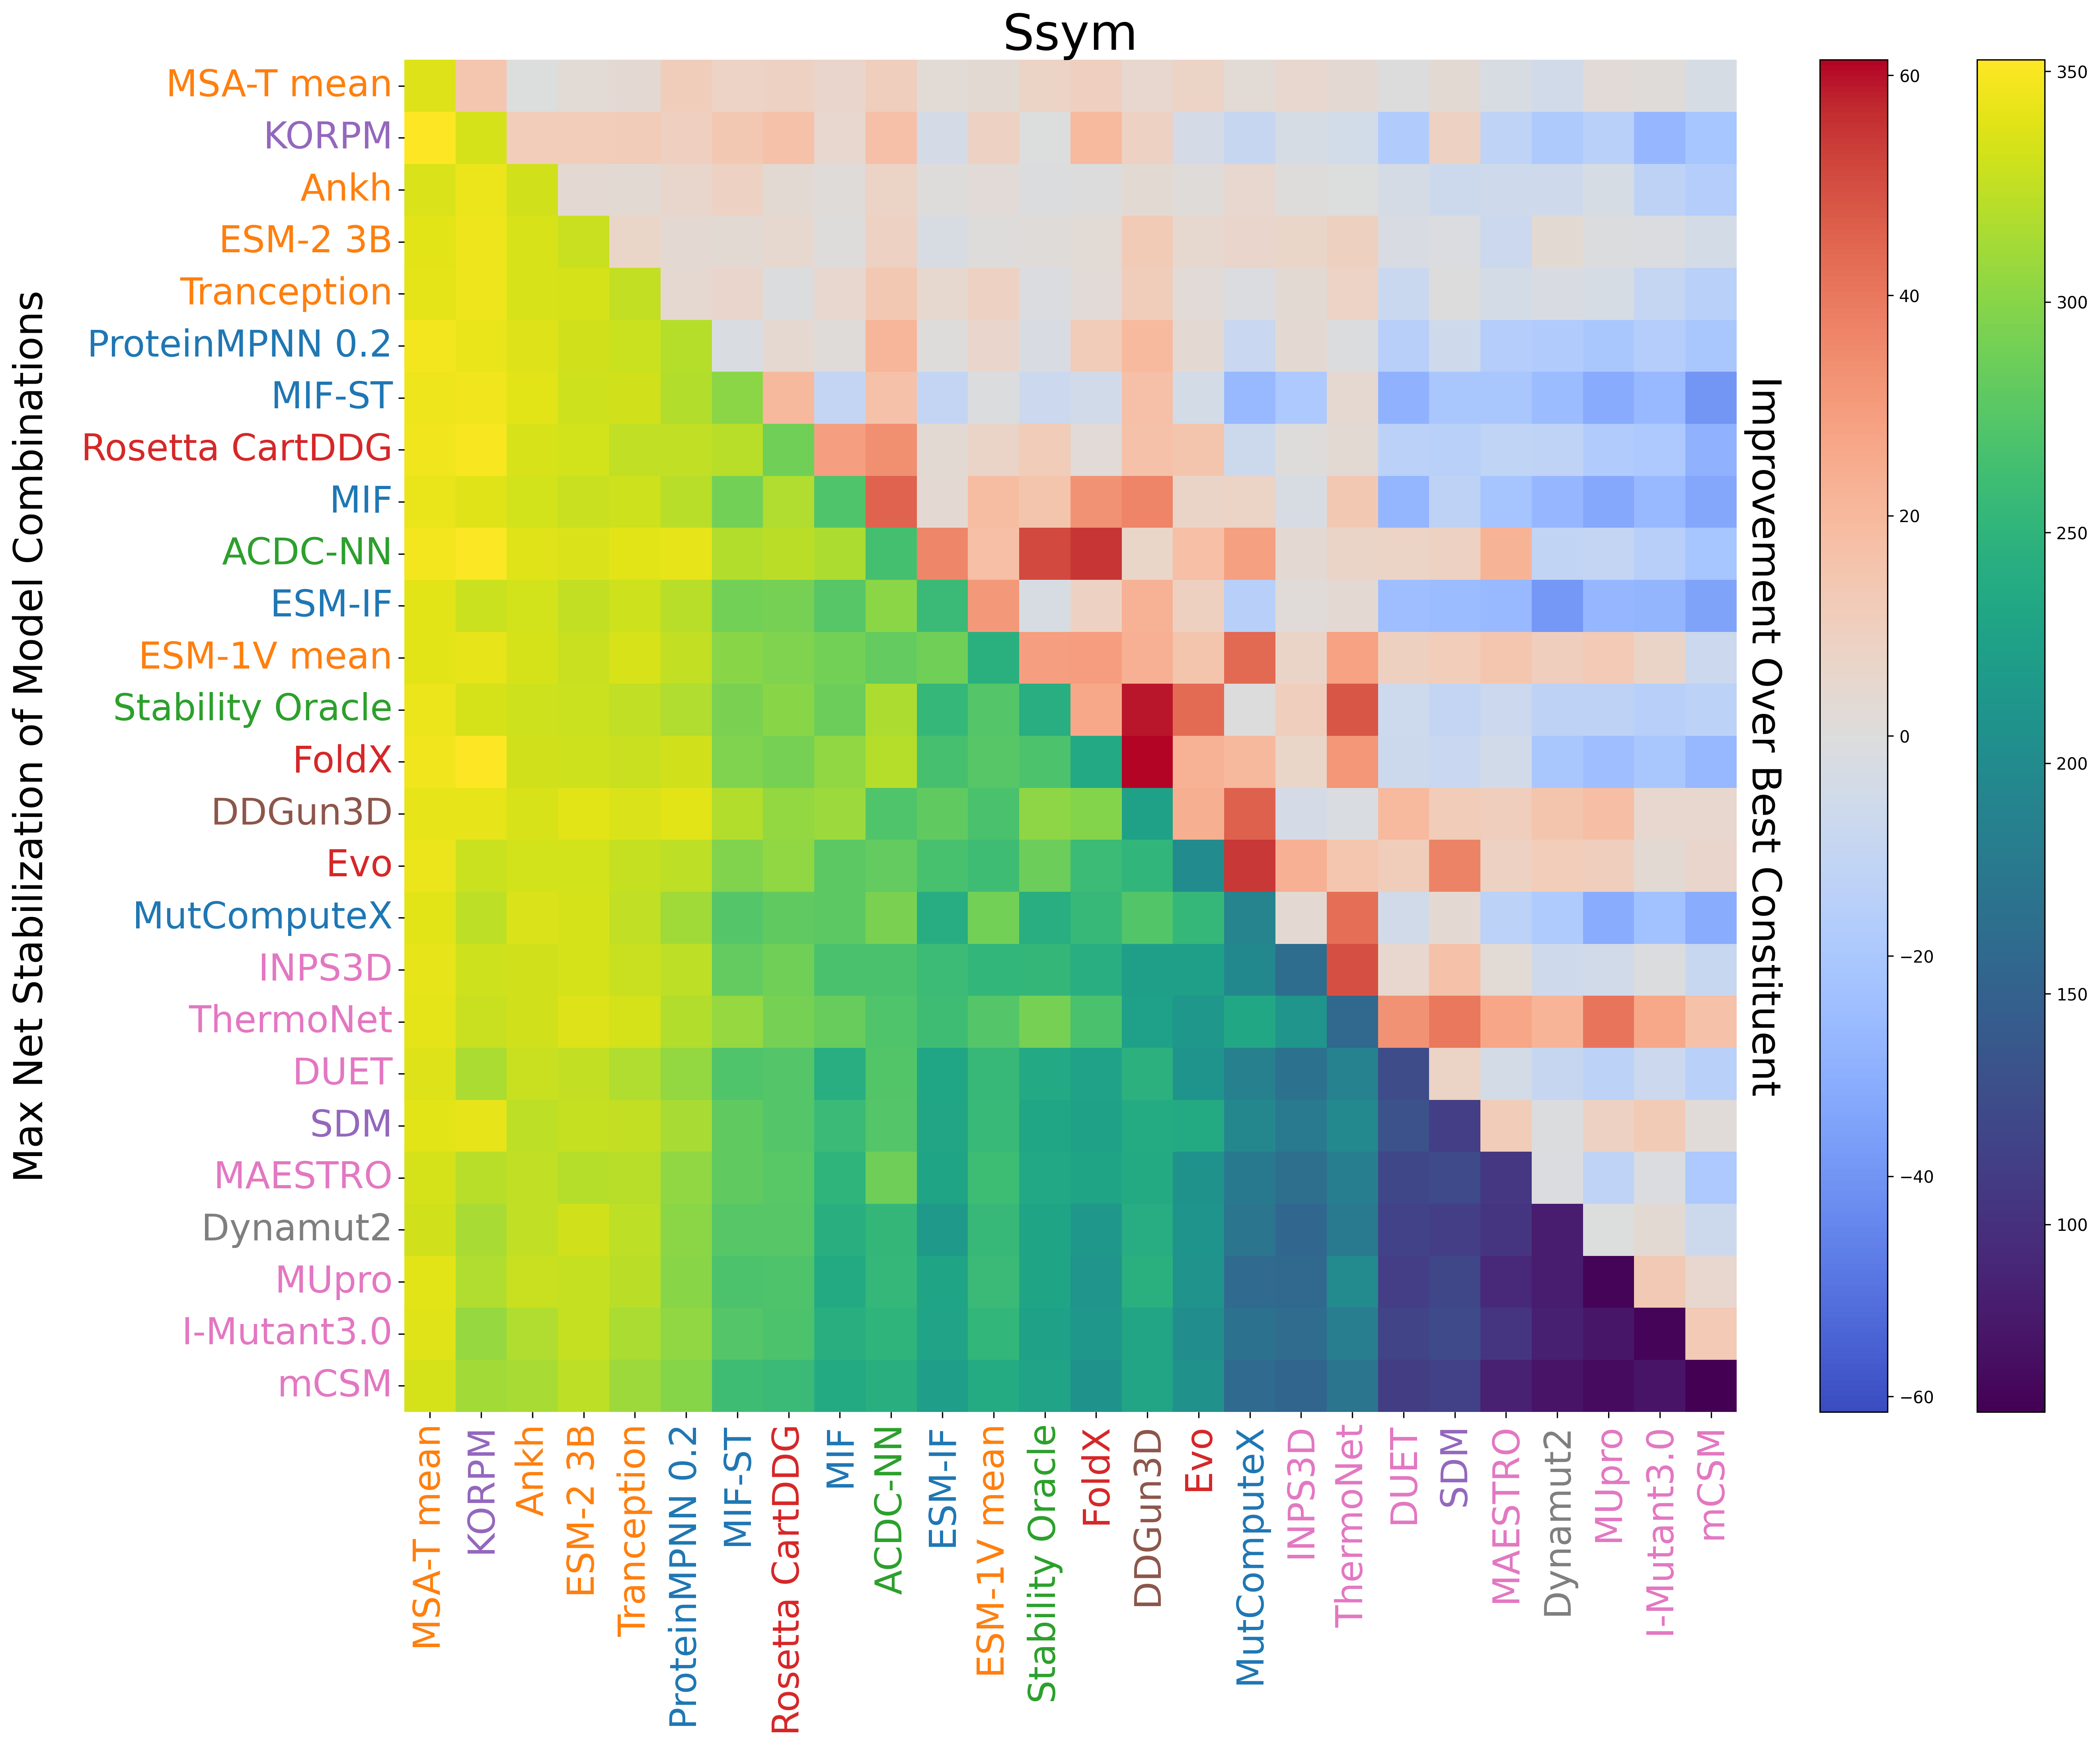

{'KORPM', 'esmif_multimer', 'Evo', 'msa_transformer_mean', 'esm2', 'FoldX', 'ACDC-NN', 'DDGun3D', 'esm1v_mean', 'SDM', 'mpnn_20_00', 'ThermoNet', 'mifst', 'tranception', 'mif', 'cartesian_ddg', 'INPS3D', 'stability-oracle', 'ankh'}


,model1,weight1,model2,weight2,net_stabilization,corr,runtime_cpu,runtime_gpu
rank,,,,,,,,
1,KORPM,1.0,FoldX,0.5,352.481,0.450146,1.0259,-0.000100
2,KORPM,1.0,msa_transformer_mean,0.2,351.551,0.660584,1.0259,4874.611195
3,KORPM,1.0,ACDC-NN,0.2,350.403,0.684548,1.0259,-0.000100
4,KORPM,1.0,cartesian_ddg,0.5,349.913,0.662762,1.0259,-0.000100
5,msa_transformer_mean,1.0,mpnn_20_00,0.5,347.661,0.658826,-0.0001,4880.719440
...,...,...,...,...,...,...,...,...
344,Dynamut2,1.0,mCSM,0.2,74.399,0.816947,-0.0001,-0.000100
345,MUpro,1.0,mCSM,0.5,67.629,0.529011,-0.0001,-0.000100
346,MUpro,1.0,MUpro,0.0,62.590,1.000000,-0.0001,-0.000100


In [ ]:
importlib.reload(analysis_utils)

subset = [#'ACDC-NN-Seq', 
        'ACDC-NN', 
        #'DDGun'
        'DDGun3D',
        'DUET',
        'Dynamut2',
        'FoldX',
        'Evo',
        'I-Mutant3.0',
        #'I-Mutant3.0-Seq',
        #'INPS-Seq',
        'INPS3D',
        'MAESTRO',
        'MUpro',
        'PopMusic',
        #'PremPS',
        'ThermoNet',
        'SAAFEC-Seq',
        'SDM',
        #'SOL_ACC',
        #'delta_kdh',
        #'delta_vol',
        #'abs_ASA',
        'ThermoNet',
        'mCSM',
        'cartesian_ddg',
        'esm1v_mean',
        #'esm2_mean',
        'esm2',
        'ankh',
        'msa_transformer_mean',
        'tranception',
        #'esmif_monomer',
        'esmif_multimer',
        'KORPM',
        'mpnn_20_00',
        'mif',
        'mifst',
        #'mpnn_mean',
        #'esmif_mean',
        #'mif_mean',
        'stability-oracle',
        'mutcomputex']

direction = 'combined'
statistic = 'net_stabilization'
upper = 'delta'

d2 = d1.copy(deep=True)

stat_df = analysis_utils.model_combinations_heatmap_2(d2, dfu_, statistic, direction, upper, subset=subset, annot=False, title='Ssym')
stat_df = stat_df.drop_duplicates(subset=[statistic]).reset_index(drop=True).sort_values(statistic, ascending=False).reset_index(drop=True).reset_index()

stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models = set(list(out['model1']) + list(out['model2']))
print(models)
stat_df

In [ ]:
stat_df_ = stat_df.applymap(lambda x: np.nan if x==-0.0001 else x)
stat_df_ = stat_df.applymap(lambda x: round(x, 2) if type(x)==float else x)
for source, target in remap_names.items():
    stat_df_.loc[stat_df_['model1']==source, 'model1'] = target
    stat_df_.loc[stat_df_['model2']==source, 'model2'] = target
stat_df_ = stat_df_.reset_index().drop('weight1', axis=1).rename({'rank': 'Rank', 'model1': 'Base model', 'model2': 'Added Model', 'weight2': 'Weight', 'corr': 'Model Correlation', 'runtime_cpu': 'CPU time (s)', 'runtime_gpu': 'GPU time (s)', 'spearman': 'Spearman\'s rho'}, axis=1)
#stat_df_.to_csv('../data/stat_df_net_stab_ssym.csv')
stat_df_.head(30)

,Rank,Base model,Added Model,Weight,net_stabilization,Model Correlation,CPU time (s),GPU time (s)
0,1,KORPM,FoldX,0.5,352.48,0.45,1.03,-0.00
1,2,KORPM,MSA-T mean,0.2,351.55,0.66,1.03,4874.61
2,3,KORPM,ACDC-NN,0.2,350.40,0.68,1.03,-0.00
3,4,KORPM,Rosetta CartDDG,0.5,349.91,0.66,1.03,-0.00
4,5,MSA-T mean,ProteinMPNN 0.2,0.5,347.66,0.66,-0.00,4880.72
5,6,ACDC-NN,MSA-T mean,1.0,347.16,0.57,-0.00,4874.61
6,7,KORPM,MIF-ST,0.2,346.70,0.67,1.03,22.22
7,8,MSA-T mean,FoldX,0.5,346.59,0.19,-0.00,4874.61
8,9,Rosetta CartDDG,MSA-T mean,1.0,345.78,0.44,-0.00,4874.61
9,10,MIF-ST,MSA-T mean,1.0,344.81,0.87,-0.00,4896.83


In [ ]:
supp = d1.xs('dir')[['auprc', 'mean_stabilization', 'net_stabilization', 'weighted_ndcg', 'weighted_spearman', 'auppc', 'aumsc', 'antisymmetry', 'bias']].reset_index().drop(['model_type', 'class'], axis=1)#.set_index('model')
selection = {'INPS3D', 'DDGun', 'PremPS', 'mif', 'DDGun3D', 'esmif_monomer', 'esm1v_mean', 'mpnn_mean', 'msa_transformer_mean', 'DUET', 'Dynamut', 'FoldX', 'I-Mutant3.0', 'I-Mutant3.0-Seq',
'tranception', 'PopMusic', 'MAESTRO', 'mifst', 'SOL_ACC', 'korpm', 'mpnn_20_00', 'esmif_multimer', 'ACDC-NN', 'cartesian_ddg', 'SAAFEC-Seq', 'SDM', 'SOL_ACC', 'ThermoNet', 'mCSM', 'ddG'}
supp[['model1', 'weight1', 'model2', 'weight2']] = supp['model'].apply(analysis_utils.process_index).apply(pd.Series)
supp = supp.loc[supp['model1'].isin(selection) & supp['model2'].isin(selection)]
df1 = analysis_utils.get_stat_df(supp, 'weighted_ndcg', new_dir='dir')
df2 = analysis_utils.get_stat_df(supp, 'auppc', new_dir='dir')
df3 = analysis_utils.get_stat_df(supp, 'net_stabilization', new_dir='dir')

assert len(df1)==len(df2)
assert len(df2)==len(df3)

#df_merged = df1.merge(df2, how='outer', on=['model1', 'weight1', 'model2', 'weight2']).merge(df3, how='outer', on=['model1', 'weight1', 'model2', 'weight2'])
df_merged = pd.concat([df1, df2['auppc'], df3['net_stabilization']], axis=1)
df_merged = df_merged.loc[(df_merged['model1']!='ddG')&(df_merged['model1']!='PremPS')]

df_merged['models'] = df_merged.apply(lambda row: set([row['model1'], row['model2']]), axis=1)
df_merged['models'] = df_merged['models'].apply(frozenset)

idx1 = df_merged.groupby('models')['weighted_ndcg'].idxmax()
idx2 = df_merged.groupby('models')['auppc'].idxmax()
idx3 = df_merged.groupby('models')['net_stabilization'].idxmax()

df_merged_2 = pd.concat([df_merged.loc[idx1], df_merged.loc[idx2], df_merged.loc[idx3]]).drop_duplicates()

dd1 = df_merged_2.sort_values('weighted_ndcg', ascending=False).head(10) #16
dd2 = df_merged_2.sort_values('auppc', ascending=False).head(10)
dd3 = df_merged_2.sort_values('net_stabilization', ascending=False).head(10)
dd = pd.concat([dd1, dd2, dd3]).drop_duplicates().drop('models', axis=1)
dd['model1'] = dd['model1'].replace(remap_names)
dd['model2'] = dd['model2'].replace(remap_names)
dd = dd.drop('weight1', axis=1)
dd.columns = ['Model 1', 'Model 2', 'Weight 2', 'wNDCG', 'AUPPC', 'Net Stabilization']
print(len(dd))
dd

23


,Model 1,Model 2,Weight 2,wNDCG,AUPPC,Net Stabilization
312,I-Mutant3.0-Seq,ACDC-NN,0.5,0.839316,0.067922,24.040
89,I-Mutant3.0-Seq,Rosetta CartDDG,0.5,0.838720,0.063948,30.151
311,I-Mutant3.0-Seq,mCSM,0.5,0.837299,0.059304,21.049
171,I-Mutant3.0-Seq,SDM,0.2,0.836452,0.059729,21.231
287,I-Mutant3.0-Seq,DUET,0.2,0.836365,0.060566,27.740
222,I-Mutant3.0-Seq,KORPM,0.2,0.836054,0.067433,23.100
17,I-Mutant3.0-Seq,Dynamut,0.2,0.835989,0.060843,18.981
264,I-Mutant3.0-Seq,ProteinMPNN 0.2,0.2,0.835319,0.060978,24.941
307,I-Mutant3.0-Seq,INPS3D,0.5,0.834490,0.067659,25.001
88,I-Mutant3.0,Rosetta CartDDG,1.0,0.833567,0.061043,32.481


In [ ]:
supp = d1.xs('combined')[['auprc', 'weighted_ndcg', 'weighted_spearman', 'mean_stabilization', 'net_stabilization', 'auppc', 'aumsc']].reset_index().drop(['model_type', 'class'], axis=1)
selection = {'INPS3D', 'DDGun', 'PremPS', 'mif', 'DDGun3D', 'esmif_monomer', 'esm1v_mean', 'mpnn_mean', 'msa_transformer_mean', 'DUET', 'Dynamut', 'FoldX', 'I-Mutant3.0', 'I-Mutant3.0-Seq',
'tranception', 'PopMusic', 'MAESTRO', 'mifst', 'SOL_ACC', 'korpm', 'mpnn_20_00', 'esmif_multimer', 'ACDC-NN', 'cartesian_ddg', 'SAAFEC-Seq', 'SDM', 'SOL_ACC', 'ThermoNet', 'mCSM', 'ddG'}
supp[['model1', 'weight1', 'model2', 'weight2']] = supp['model'].apply(analysis_utils.process_index).apply(pd.Series)
supp = supp.loc[supp['model1'].isin(selection) & supp['model2'].isin(selection)]
df1 = analysis_utils.get_stat_df(supp, 'weighted_ndcg', new_dir='')
df2 = analysis_utils.get_stat_df(supp, 'auppc', new_dir='')
df3 = analysis_utils.get_stat_df(supp, 'net_stabilization', new_dir='')

assert len(df1)==len(df2)
assert len(df2)==len(df3)

#df_merged = df1.merge(df2, how='outer', on=['model1', 'weight1', 'model2', 'weight2']).merge(df3, how='outer', on=['model1', 'weight1', 'model2', 'weight2'])
df_merged = pd.concat([df1, df2['auppc'], df3['net_stabilization']], axis=1)
df_merged = df_merged.loc[(df_merged['model1']!='ddG')&(df_merged['model1']!='PremPS')]

df_merged['models'] = df_merged.apply(lambda row: set([row['model1'], row['model2']]), axis=1)
df_merged['models'] = df_merged['models'].apply(frozenset)

idx1 = df_merged.groupby('models')['weighted_ndcg'].idxmax()
idx2 = df_merged.groupby('models')['auppc'].idxmax()
idx3 = df_merged.groupby('models')['net_stabilization'].idxmax()

df_merged_2 = pd.concat([df_merged.loc[idx1], df_merged.loc[idx2], df_merged.loc[idx3]]).drop_duplicates()

dd1 = df_merged_2.sort_values('weighted_ndcg', ascending=False).head(10) #16
dd2 = df_merged_2.sort_values('auppc', ascending=False).head(10)
dd3 = df_merged_2.sort_values('net_stabilization', ascending=False).head(10)
dd = pd.concat([dd1, dd2, dd3]).drop_duplicates().drop('models', axis=1)
dd['model1'] = dd['model1'].replace(remap_names)
dd['model2'] = dd['model2'].replace(remap_names)
dd = dd.drop('weight1', axis=1)
dd.columns = ['Model 1', 'Model 2', 'Weight 2', 'wNDCG', 'AUPPC', 'Net Stabilization']
print(len(dd))
dd

26


,Model 1,Model 2,Weight 2,wNDCG,AUPPC,Net Stabilization
224,KORPM,MAESTRO,0.5,0.896518,0.447761,320.571
54,FoldX,MSA-T mean,0.5,0.886000,0.449631,346.589
82,Rosetta CartDDG,KORPM,0.5,0.884911,0.454668,349.913
77,Rosetta CartDDG,MSA-T mean,0.2,0.881138,0.459898,345.781
329,DDGun3D,MAESTRO,0.5,0.880485,0.429935,237.352
91,Rosetta CartDDG,MAESTRO,0.5,0.880379,0.425786,276.083
328,DDGun,MAESTRO,0.5,0.880253,0.436462,251.351
84,Rosetta CartDDG,MIF-ST,0.2,0.880185,0.449933,321.463
90,Rosetta CartDDG,INPS3D,0.2,0.879292,0.436617,289.412
72,ACDC-NN,FoldX,0.5,0.878050,0.451317,320.161


In [ ]:
rand = class_result.reset_index()
rand = rand.loc[rand['model'].str.contains('random')]
rand['model'] = 'random'
rand['model_type'] = np.nan
rand = rand.set_index(['direction', 'model_type', 'model'])
dr = pd.concat([d1.reset_index(), rand.reset_index()])
dr = dr.set_index(['direction', 'model_type', 'model'])

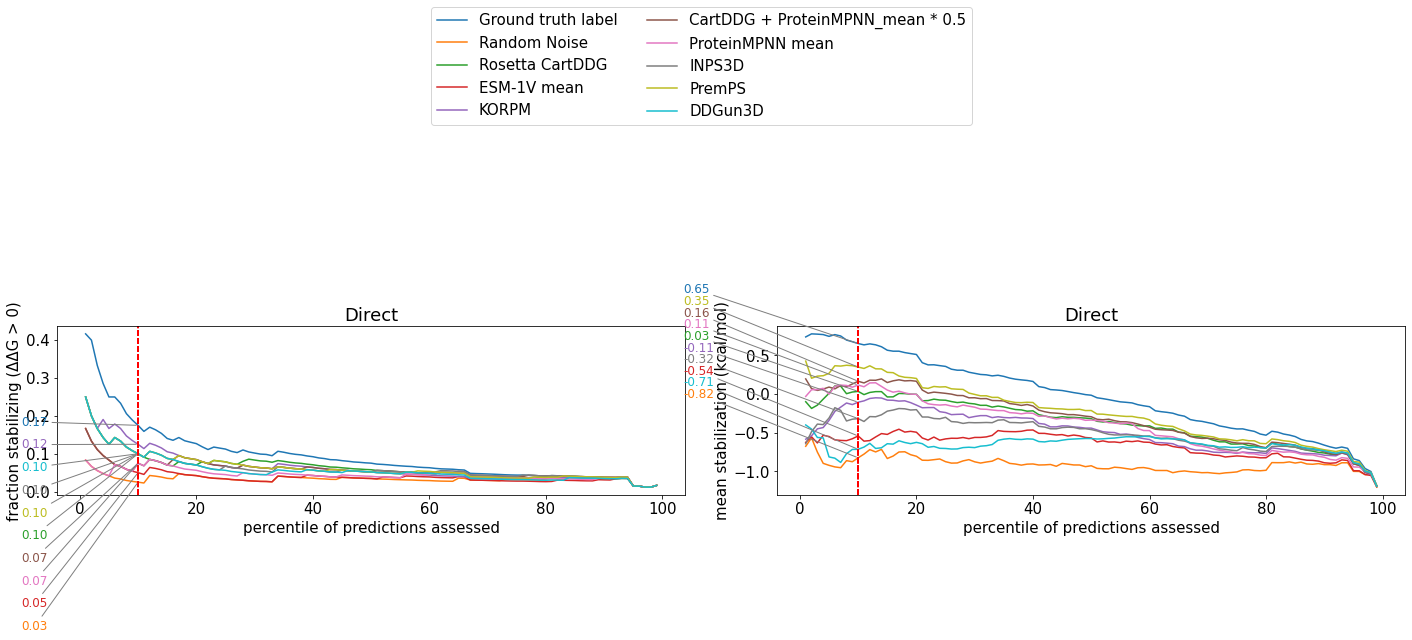

In [ ]:
analysis_utils.recovery_curves_2(dr, ['cartesian_ddg + mpnn_mean * 0.5', 'mpnn_mean', 'PremPS', 'cartesian_ddg', 'esm1v_mean', 'PremPS', 'korpm', 'DDGun3D', 'INPS3D', 'ddG', 'random'], percentile_labels=[10], directions=['dir'])

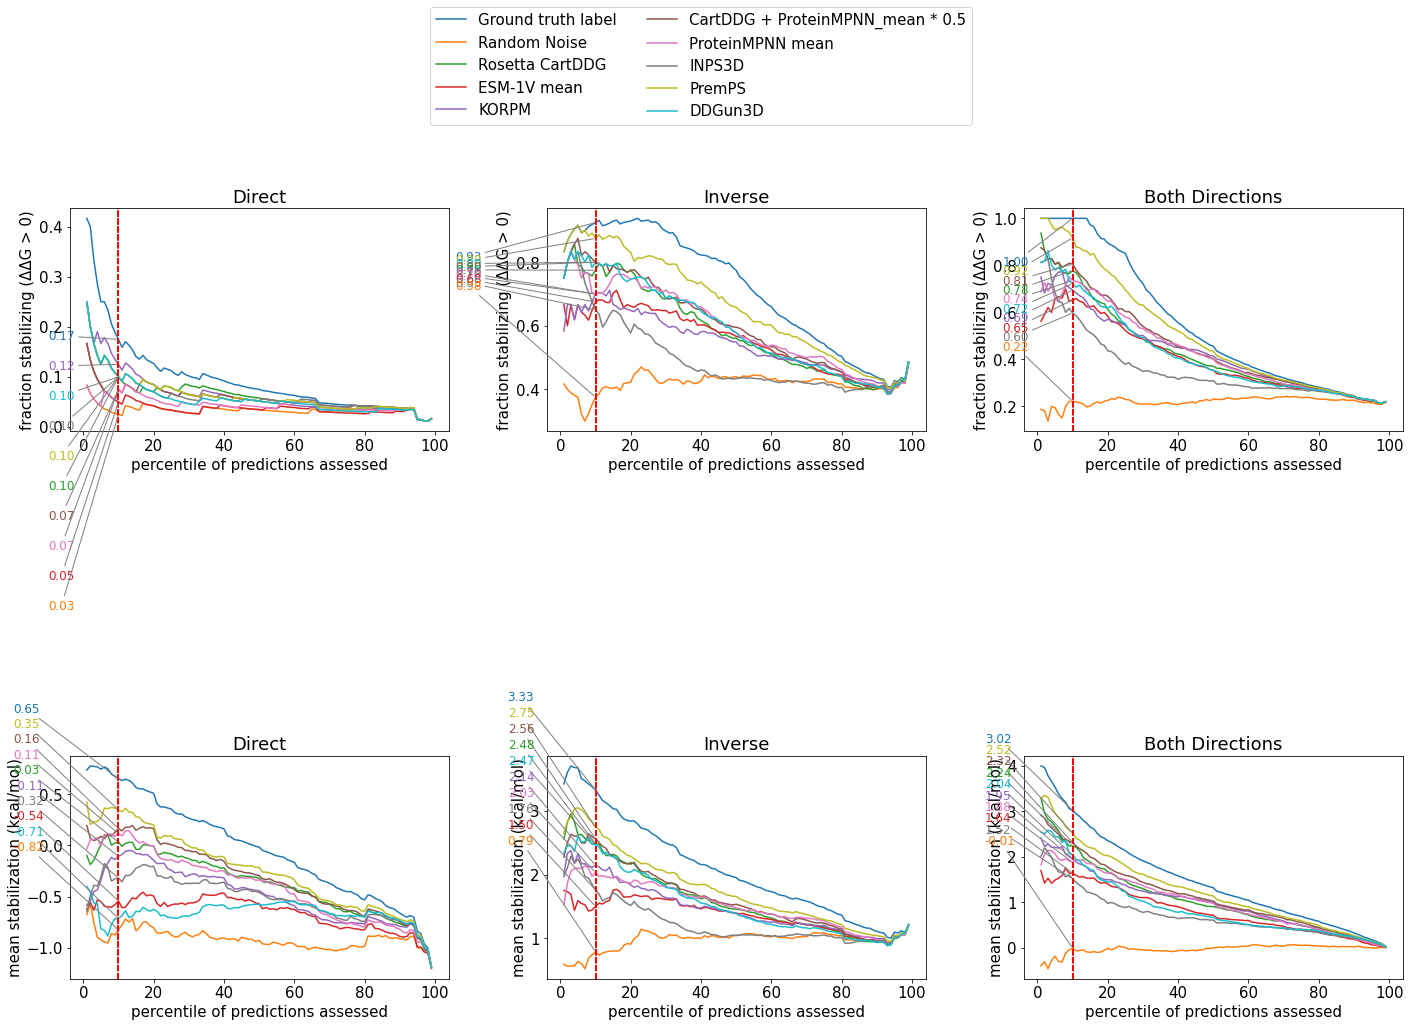

In [ ]:
analysis_utils.recovery_curves_2(dr, ['cartesian_ddg + mpnn_mean * 0.5', 'mpnn_mean', 'PremPS', 'cartesian_ddg', 'esm1v_mean', 'PremPS', 'korpm', 'DDGun3D', 'INPS3D', 'ddG', 'random'], directions=['dir', 'inv'], percentile_labels=[10])

In [ ]:
pd.concat([dr.xs('dir').sort_values('90%', ascending=False).head(10)[['90%', '90$', 'net_stabilization']], dr.xs('dir').sort_values('90$', ascending=False).head(10).tail(9)[['90%', '90$', 'net_stabilization']]])

90%       90$  \
model_type   model                                                  
NaN          Cartddg                           0.037931 -0.759107   
supervised   INPS-Seq + mifst * 1              0.037931 -0.756038   
             INPS-Seq + mifst * 0.2            0.037931 -0.751521   
             INPS-Seq + mif_mean * 1           0.037931 -0.768417   
             INPS-Seq + mif_mean * 0.5         0.037931 -0.752555   
             INPS-Seq + mif_mean * 0.2         0.037931 -0.749797   
             INPS-Seq + mif * 1                0.037931 -0.744969   
             INPS-Seq + mif * 0.5              0.037931 -0.752555   
             INPS-Seq + mif * 0.2              0.037931 -0.752210   
             INPS-Seq + mCSM * 0.2             0.037931 -0.760486   
evolutionary ddG + msa_transformer_mean * 0.2  0.037931 -0.660176   
supervised   ddG + MUpro * 0.2                 0.037931 -0.660176   
NaN          ddG + cluster * 1                 0.037931 -0.660176   
             cluster + ddG * 0.2               0.037931 -0.660176   
             cluster + ddG * 0.5               0.037931 -0.660176   
             cluster + ddG * 1                 0.037931 -0.660176   
supervised   ddG + SAAFEC-SEQ * 0.2            0.037931 -0.660176   
NaN          ddG                               0.037931 -0.660176   
             ddG + DDG * 0.2                   0.037931 -0.660176   

                                               net_stabilization  
model_type   model                                                
NaN          Cartddg                                      23.080  
supervised   INPS-Seq + mifst * 1                         -5.639  
             INPS-Seq + mifst * 0.2                      -26.349  
             INPS-Seq + mif_mean * 1                       0.761  
             INPS-Seq + mif_mean * 0.5                     5.261  
             INPS-Seq + mif_mean * 0.2                   -23.649  
             INPS-Seq + mif * 1                            6.591  
             INPS-Seq + mif * 0.5                          4.611  
             INPS-Seq + mif * 0.2                        -21.719  
             INPS-Seq + mCSM * 0.2                       -16.550  
evolutionary ddG + msa_transformer_mean * 0.2             54.950  
supervised   ddG + MUpro * 0.2                            56.700  
NaN          ddG + cluster * 1                          -140.191  
             cluster + ddG * 0.2                        -321.941  
             cluster + ddG * 0.5                        -300.291  
             cluster + ddG * 1                          -140.191  
supervised   ddG + SAAFEC-SEQ * 0.2                       54.400  
NaN          ddG                                          57.531  
             ddG + DDG * 0.2                              57.461